In [3]:
import numpy as np
import tensorflow as tf
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
from tqdm import tqdm 
import torch.nn.functional as Func

In [4]:
class Expert(nn.Module):
    def __init__(self, input_size):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_size, 800)
        self.fc2 = nn.Linear(800, 800)
        self.fc3 = nn.Linear(800, 800)
        self.fc4 = nn.Linear(800,1)
        self.sigmoid = nn.Sigmoid()
        self.relu=Func.relu
        self.batch = nn.BatchNorm1d(800)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x
  

class Gating(nn.Module):
    def __init__(self, input_size, num_experts):
        super(Gating, self).__init__()
        self.fc1 = nn.Linear(input_size, num_experts)
        self.SftMax = nn.functional.softmax

    def forward(self, x):
        x = self.SftMax(self.fc1(x))
        # print("X value",x)
        return x
  

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Expert_model = Expert(32*32*3).to(device)


In [6]:
Expert_model

Expert(
  (fc1): Linear(in_features=3072, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=800, bias=True)
  (fc3): Linear(in_features=800, out_features=800, bias=True)
  (fc4): Linear(in_features=800, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (batch): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [7]:
# from torch._C import float32
def train(model,optimizer,loss_function,device,train_data,Gamma=5):
  correct_train_pred = 0
  total_samples = 0
  total_batches = 0 
  for i, (images, labels) in enumerate(train_data):


    images = images.reshape(-1, 32*32*3)

    images = images.to(device)
    labels = torch.tensor(labels,dtype=torch.float32).to(device)
    # labels = labels.to(device)
    outputs = model(images)
    # print(outputs)
    

    loss = loss_function(outputs,labels)

    optimizer.zero_grad()
    # print(type(labels[0].item()))
    # print(type(outputs[0].item()))
    # print(labels.dtype)
    # print(outputs.dtype)
    # print(loss)
    # print(type(loss))
    # print(loss)
    loss.backward()
    optimizer.step()

    total_batches+=1

    # predClass = torch.max(outputs.data, 1)[1]
    predClass = [1.0 if i > 0.6 else 0.0 for i in outputs]
    
    predClass = torch.tensor(predClass).to(device)
    # print(predClass)
    # print(labels)

    correct_train_pred += (predClass==labels).sum()
    total_samples += len(labels)
  return correct_train_pred/total_samples

def evaluate(model,loader,device,loss_function):
  correct=0
  total_samples = 0
  for i, (images,labels) in enumerate(loader):
    images = images.reshape(-1, 32*32*3)

    images = images.to(device)
    labels = labels.to(device)

    pred_output = model(images)
    loss=loss_function(pred_output,labels)
    predClass = [1.0 if i > 0.6 else 0.0 for i in pred_output]

    # predClass = torch.max(pred_output.data, 1)[1]


    # print("eval func",predClass)
    predClass = torch.tensor(predClass).to(device)
    correct+=(predClass==labels).sum()
    total_samples+=len(labels)
  return correct/total_samples
  

In [8]:
lmda = lambda y : float(y > 1 and y < 8)

# def func(perc):
#   ctr = 0
#   ctr < perc:
#     y = random(0,10)
#     ctr += 1


#load and prepare the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform,target_transform=lmda)
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), int(len(train_dataset) * 0.15)], generator=torch.Generator().manual_seed(1))

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform,target_transform=lmda)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)


100%|██████████| 170498071/170498071 [00:03<00:00, 49147158.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [21]:
# no_experts= 5

# fraction = 1/no_experts
# total = len(train_dataset)
# list_for_split = [int(total*fraction)]*no_experts

# op = torch.utils.data.random_split(train_dataset,list_for_split,generator = torch.Generator().manual_seed(1))

def TrainExperts(NumOfExperts):
  # new_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform,target_transform=lmda)
  fraction = 1/NumOfExperts
  total = len(train_dataset)
  list_for_split = [int(total*fraction)]*NumOfExperts
  # list_for_split = [8333,8333,8333,8333,8333,8335]

  dataset_list = torch.utils.data.random_split(train_dataset,list_for_split,generator = torch.Generator().manual_seed(1))

  model_list=[]
  for i in range(NumOfExperts):
    new_train_loader = torch.utils.data.DataLoader(dataset_list[i], batch_size=64, shuffle=True)
    Expert_model = Expert(32*32*3).to(device)
    Expert_model.train()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(Expert_model.parameters(), lr=0.0001)

    EPOCHS = 20
    train_accuracy = 0

    ModelName="Expert_Model_1.pt"

    ValAccuracy = 0
    TrainAcc_List = []
    ValAcc_List = []
    for i in tqdm(range(EPOCHS)):
      train_accuracy = train(Expert_model,optimizer,loss_function,device,new_train_loader)
      val_acc = evaluate(Expert_model,val_loader,device,loss_function)
      TrainAcc_List.append(train_accuracy.cpu().item())
      ValAcc_List.append(val_acc.cpu().item())

      print("EPOCH - ", i+1, ". Train Accuracy = ", train_accuracy.cpu().item(), ", Validation Accuracy = ", val_acc.cpu().item())

      if val_acc.cpu().item() > ValAccuracy:
        print("Model Re-Saved")
        ValAccuracy = val_acc.cpu().item()
        torch.save(Expert_model, ModelName)
    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)
    model_list.append(saved_model)


    # Train_Accuracy = evaluate(saved_model, new_train_loader, device)
    # print("Train Accuracy = ", Train_Accuracy.cpu().item())
    # Test_Accuracy = evaluate(saved_model, test_loader, device)
    # print("Test Accuracy = ", Test_Accuracy.cpu().item())

    # print("Generalization Gap = ", (Train_Accuracy.cpu().item() - Test_Accuracy.cpu().item()))

  return model_list



In [10]:
# from torch._C import float32
def trainGated(Gatedmodel,optimizer,loss_function,device,train_data, model_list,Gamma=5):
  correct_train_pred = 0
  total_samples = 0
  total_batches = 0 
  for k, (images, labels) in enumerate(train_data):


    images = images.reshape(-1, 32*32*3)

    images = images.to(device)
    labels = torch.tensor(labels,dtype=torch.float32).to(device)
    
    
    optimizer.zero_grad()

    loss = 0
    for i in range(len(images)):
      # labels = labels.to(device)
      outputs = Gatedmodel(images[i])
      # print(outputs)
      for j in range(len(model_list)):
        loss += outputs[j] * ((labels[i] - model_list[j](images[i]))**2) 
        # loss += outputs[j] * torch.exp(labels - model_list[j](images)) #----------------------------->change
      
      # loss = -1 * torch.log(loss)
      # print("loss",loss)

    # loss = loss_function(outputs,labels)

    # print(type(labels[0].item()))
    # print(type(outputs[0].item()))
    # print(labels.dtype)
    # print(outputs.dtype)
    # print(loss)
    # print(type(loss))
    # print(loss)
    loss.backward()
    optimizer.step()

    total_batches+=1

    # predClass = torch.max(outputs.data, 1)[1]
    # predClass = [1.0 if i > 0.5 else 0.0 for i in outputs]
    
    # predClass = torch.tensor(predClass).to(device)
    # print(predClass)
    # print(labels)

    # correct_train_pred += (predClass==labels).sum()
    # total_samples += len(labels)
  return loss

def evaluateGated(GatedModel,loader,device, model_List):
  correct=0
  total_samples = 0
  for i, (images,labels) in enumerate(loader):
    images = images.reshape(-1, 32*32*3)

    images = images.to(device)
    labels = labels.to(device)

    for k in range(len(images)):
      image = images[k].to(device)
      GateProb = GatedModel(image)
      # print(type(GateProb),GateProb)
      # break
    # GateProb = GatedModel(images)
      pred = 0
    # print(type(GateProb),GateProb)

      for j in range(len(model_List)):
        pred += GateProb[j] * model_List[j](image)
        # print("pred value",pred)
      # print("final prediction",pred)
      # pred = GateProb *
      if (pred > 0.6 and labels[k] == 1) or (pred <= 0.6 and labels[k] == 0):
        correct += 1
      total_samples += 1
    
    
  return correct/total_samples
  

In [11]:
ExpertModels = TrainExperts(2)

Gating_model = Gating(32*32*3, 2).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(Gating_model.parameters(), lr=0.0001)

trainGated(Gating_model,AdamOpt,loss_criteria,device,train_loader, ExpertModels)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
<ipython-input-7-16fd9ccb850e>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch

EPOCH -  1 . Train Accuracy =  0.4432399868965149 , Validation Accuracy =  0.41333332657814026
Model Re-Saved


 10%|█         | 2/20 [00:26<03:55, 13.08s/it]

EPOCH -  2 . Train Accuracy =  0.45607998967170715 , Validation Accuracy =  0.4569333493709564
Model Re-Saved


 15%|█▌        | 3/20 [00:38<03:30, 12.40s/it]

EPOCH -  3 . Train Accuracy =  0.4760800004005432 , Validation Accuracy =  0.5551999807357788
Model Re-Saved


 20%|██        | 4/20 [00:49<03:12, 12.06s/it]

EPOCH -  4 . Train Accuracy =  0.47999998927116394 , Validation Accuracy =  0.5269333124160767


 25%|██▌       | 5/20 [01:04<03:13, 12.90s/it]

EPOCH -  5 . Train Accuracy =  0.48027998208999634 , Validation Accuracy =  0.5548000335693359


 30%|███       | 6/20 [01:16<02:55, 12.54s/it]

EPOCH -  6 . Train Accuracy =  0.49003997445106506 , Validation Accuracy =  0.5821333527565002
Model Re-Saved


 35%|███▌      | 7/20 [01:27<02:40, 12.33s/it]

EPOCH -  7 . Train Accuracy =  0.5139999985694885 , Validation Accuracy =  0.3959999978542328


 40%|████      | 8/20 [01:40<02:26, 12.24s/it]

EPOCH -  8 . Train Accuracy =  0.5125200152397156 , Validation Accuracy =  0.39613333344459534


 45%|████▌     | 9/20 [01:52<02:14, 12.24s/it]

EPOCH -  9 . Train Accuracy =  0.4914399981498718 , Validation Accuracy =  0.3957333266735077


 50%|█████     | 10/20 [02:04<02:03, 12.31s/it]

EPOCH -  10 . Train Accuracy =  0.5049200057983398 , Validation Accuracy =  0.607866644859314
Model Re-Saved


 55%|█████▌    | 11/20 [02:16<01:50, 12.28s/it]

EPOCH -  11 . Train Accuracy =  0.5102399587631226 , Validation Accuracy =  0.5501333475112915


 60%|██████    | 12/20 [02:28<01:37, 12.22s/it]

EPOCH -  12 . Train Accuracy =  0.5548399686813354 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [02:41<01:25, 12.15s/it]

EPOCH -  13 . Train Accuracy =  0.5389999747276306 , Validation Accuracy =  0.48186665773391724


 70%|███████   | 14/20 [02:52<01:12, 12.02s/it]

EPOCH -  14 . Train Accuracy =  0.5173199772834778 , Validation Accuracy =  0.41600000858306885


 75%|███████▌  | 15/20 [03:05<01:00, 12.18s/it]

EPOCH -  15 . Train Accuracy =  0.4806399941444397 , Validation Accuracy =  0.604533314704895


 80%|████████  | 16/20 [03:17<00:48, 12.07s/it]

EPOCH -  16 . Train Accuracy =  0.5402399897575378 , Validation Accuracy =  0.4026666581630707


 85%|████████▌ | 17/20 [03:29<00:36, 12.03s/it]

EPOCH -  17 . Train Accuracy =  0.48871999979019165 , Validation Accuracy =  0.46853333711624146


 90%|█████████ | 18/20 [03:40<00:24, 12.01s/it]

EPOCH -  18 . Train Accuracy =  0.494159996509552 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [03:52<00:11, 11.92s/it]

EPOCH -  19 . Train Accuracy =  0.5326799750328064 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [04:04<00:00, 12.25s/it]


EPOCH -  20 . Train Accuracy =  0.5149999856948853 , Validation Accuracy =  0.5914666652679443


  5%|▌         | 1/20 [00:11<03:42, 11.69s/it]

EPOCH -  1 . Train Accuracy =  0.44947999715805054 , Validation Accuracy =  0.40373334288597107
Model Re-Saved


 10%|█         | 2/20 [00:23<03:31, 11.73s/it]

EPOCH -  2 . Train Accuracy =  0.46799999475479126 , Validation Accuracy =  0.5504000186920166
Model Re-Saved


 15%|█▌        | 3/20 [00:35<03:19, 11.76s/it]

EPOCH -  3 . Train Accuracy =  0.4711199998855591 , Validation Accuracy =  0.5630666613578796
Model Re-Saved


 20%|██        | 4/20 [00:47<03:08, 11.76s/it]

EPOCH -  4 . Train Accuracy =  0.49403998255729675 , Validation Accuracy =  0.4959999918937683


 25%|██▌       | 5/20 [00:59<02:58, 11.89s/it]

EPOCH -  5 . Train Accuracy =  0.5117999911308289 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [01:10<02:45, 11.85s/it]

EPOCH -  6 . Train Accuracy =  0.5169999599456787 , Validation Accuracy =  0.3957333266735077


 35%|███▌      | 7/20 [01:22<02:34, 11.85s/it]

EPOCH -  7 . Train Accuracy =  0.4958399832248688 , Validation Accuracy =  0.6010666489601135
Model Re-Saved


 40%|████      | 8/20 [01:34<02:21, 11.81s/it]

EPOCH -  8 . Train Accuracy =  0.5254799723625183 , Validation Accuracy =  0.5985333323478699


 45%|████▌     | 9/20 [01:46<02:09, 11.79s/it]

EPOCH -  9 . Train Accuracy =  0.5375199913978577 , Validation Accuracy =  0.4161333441734314


 50%|█████     | 10/20 [01:58<01:58, 11.89s/it]

EPOCH -  10 . Train Accuracy =  0.5471199750900269 , Validation Accuracy =  0.5009333491325378


 55%|█████▌    | 11/20 [02:10<01:46, 11.88s/it]

EPOCH -  11 . Train Accuracy =  0.5368399620056152 , Validation Accuracy =  0.3962666690349579


 60%|██████    | 12/20 [02:22<01:34, 11.87s/it]

EPOCH -  12 . Train Accuracy =  0.5060399770736694 , Validation Accuracy =  0.39586666226387024


 65%|██████▌   | 13/20 [02:33<01:22, 11.83s/it]

EPOCH -  13 . Train Accuracy =  0.551800012588501 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [02:45<01:10, 11.78s/it]

EPOCH -  14 . Train Accuracy =  0.5187999606132507 , Validation Accuracy =  0.6017333269119263
Model Re-Saved


 75%|███████▌  | 15/20 [02:57<00:59, 11.85s/it]

EPOCH -  15 . Train Accuracy =  0.5653600096702576 , Validation Accuracy =  0.5421333312988281


 80%|████████  | 16/20 [03:09<00:47, 11.88s/it]

EPOCH -  16 . Train Accuracy =  0.5198000073432922 , Validation Accuracy =  0.5994666814804077


 85%|████████▌ | 17/20 [03:21<00:35, 11.82s/it]

EPOCH -  17 . Train Accuracy =  0.5267199873924255 , Validation Accuracy =  0.604533314704895
Model Re-Saved


 90%|█████████ | 18/20 [03:32<00:23, 11.83s/it]

EPOCH -  18 . Train Accuracy =  0.5557999610900879 , Validation Accuracy =  0.7574666738510132
Model Re-Saved


 95%|█████████▌| 19/20 [03:44<00:11, 11.79s/it]

EPOCH -  19 . Train Accuracy =  0.5507599711418152 , Validation Accuracy =  0.604533314704895


100%|██████████| 20/20 [03:56<00:00, 11.83s/it]

EPOCH -  20 . Train Accuracy =  0.5170400142669678 , Validation Accuracy =  0.6043999791145325



<ipython-input-4-1840de26fea6>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


tensor([0.8124], device='cuda:0', grad_fn=<AddBackward0>)

In [12]:
List_observations=[0.5762]

In [14]:
val=evaluateGated(Gating_model,test_loader,device, ExpertModels)
print(val)
List_observations.append(val)

<ipython-input-4-1840de26fea6>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


0.6508


In [15]:
ExpertModels = TrainExperts(4)

Gating_model = Gating(32*32*3, 4).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(Gating_model.parameters(), lr=0.0001)

trainGated(Gating_model,AdamOpt,loss_criteria,device,train_loader, ExpertModels)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-7-16fd9ccb850e>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels,dtype=torch.float32).to(device)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  5%|▌         | 1/20 [00:07<02:26,  7.70s/it]

EPOCH -  1 . Train Accuracy =  0.4342399835586548 , Validation Accuracy =  0.3959999978542328
Model Re-Saved


 10%|█         | 2/20 [00:14<02:11,  7.30s/it]

EPOCH -  2 . Train Accuracy =  0.44711998105049133 , Validation Accuracy =  0.3981333374977112
Model Re-Saved


 15%|█▌        | 3/20 [00:22<02:05,  7.37s/it]

EPOCH -  3 . Train Accuracy =  0.4644799828529358 , Validation Accuracy =  0.547866702079773
Model Re-Saved


 20%|██        | 4/20 [00:29<01:54,  7.18s/it]

EPOCH -  4 . Train Accuracy =  0.4851199984550476 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:36<01:48,  7.25s/it]

EPOCH -  5 . Train Accuracy =  0.4525599777698517 , Validation Accuracy =  0.45840001106262207


 30%|███       | 6/20 [00:43<01:42,  7.35s/it]

EPOCH -  6 . Train Accuracy =  0.4779999852180481 , Validation Accuracy =  0.5209333300590515


 35%|███▌      | 7/20 [00:50<01:33,  7.20s/it]

EPOCH -  7 . Train Accuracy =  0.4801599979400635 , Validation Accuracy =  0.5784000158309937
Model Re-Saved


 40%|████      | 8/20 [00:58<01:27,  7.30s/it]

EPOCH -  8 . Train Accuracy =  0.491599977016449 , Validation Accuracy =  0.4094666838645935


 45%|████▌     | 9/20 [01:05<01:18,  7.14s/it]

EPOCH -  9 . Train Accuracy =  0.4840799868106842 , Validation Accuracy =  0.45866668224334717


 50%|█████     | 10/20 [01:12<01:13,  7.31s/it]

EPOCH -  10 . Train Accuracy =  0.4877599775791168 , Validation Accuracy =  0.4343999922275543


 55%|█████▌    | 11/20 [01:20<01:06,  7.34s/it]

EPOCH -  11 . Train Accuracy =  0.4808799922466278 , Validation Accuracy =  0.4083999991416931


 60%|██████    | 12/20 [01:27<00:57,  7.18s/it]

EPOCH -  12 . Train Accuracy =  0.46807998418807983 , Validation Accuracy =  0.5898666977882385
Model Re-Saved


 65%|██████▌   | 13/20 [01:34<00:50,  7.26s/it]

EPOCH -  13 . Train Accuracy =  0.5115999579429626 , Validation Accuracy =  0.5738666653633118


 70%|███████   | 14/20 [01:41<00:42,  7.13s/it]

EPOCH -  14 . Train Accuracy =  0.5452799797058105 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [01:48<00:36,  7.20s/it]

EPOCH -  15 . Train Accuracy =  0.485759973526001 , Validation Accuracy =  0.39746665954589844


 80%|████████  | 16/20 [01:56<00:29,  7.25s/it]

EPOCH -  16 . Train Accuracy =  0.4992799758911133 , Validation Accuracy =  0.605733335018158
Model Re-Saved


 85%|████████▌ | 17/20 [02:03<00:21,  7.16s/it]

EPOCH -  17 . Train Accuracy =  0.515999972820282 , Validation Accuracy =  0.4026666581630707


 90%|█████████ | 18/20 [02:10<00:14,  7.37s/it]

EPOCH -  18 . Train Accuracy =  0.5014399886131287 , Validation Accuracy =  0.6285333633422852
Model Re-Saved


 95%|█████████▌| 19/20 [02:17<00:07,  7.23s/it]

EPOCH -  19 . Train Accuracy =  0.5285599827766418 , Validation Accuracy =  0.6055999994277954


100%|██████████| 20/20 [02:25<00:00,  7.28s/it]


EPOCH -  20 . Train Accuracy =  0.5201599597930908 , Validation Accuracy =  0.6334666609764099
Model Re-Saved


  5%|▌         | 1/20 [00:07<02:23,  7.56s/it]

EPOCH -  1 . Train Accuracy =  0.439520001411438 , Validation Accuracy =  0.4787999987602234
Model Re-Saved


 10%|█         | 2/20 [00:14<02:09,  7.19s/it]

EPOCH -  2 . Train Accuracy =  0.45879998803138733 , Validation Accuracy =  0.395466685295105


 15%|█▌        | 3/20 [00:22<02:04,  7.35s/it]

EPOCH -  3 . Train Accuracy =  0.46031999588012695 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:28<01:54,  7.16s/it]

EPOCH -  4 . Train Accuracy =  0.45080000162124634 , Validation Accuracy =  0.4817333519458771
Model Re-Saved


 25%|██▌       | 5/20 [00:36<01:49,  7.30s/it]

EPOCH -  5 . Train Accuracy =  0.4745599925518036 , Validation Accuracy =  0.4029333293437958


 30%|███       | 6/20 [00:44<01:45,  7.51s/it]

EPOCH -  6 . Train Accuracy =  0.4687199890613556 , Validation Accuracy =  0.5691999793052673
Model Re-Saved


 35%|███▌      | 7/20 [00:51<01:35,  7.35s/it]

EPOCH -  7 . Train Accuracy =  0.4769599735736847 , Validation Accuracy =  0.3959999978542328


 40%|████      | 8/20 [00:59<01:29,  7.44s/it]

EPOCH -  8 . Train Accuracy =  0.4635999798774719 , Validation Accuracy =  0.571066677570343
Model Re-Saved


 45%|████▌     | 9/20 [01:05<01:20,  7.27s/it]

EPOCH -  9 . Train Accuracy =  0.48495998978614807 , Validation Accuracy =  0.591866672039032
Model Re-Saved


 50%|█████     | 10/20 [01:13<01:13,  7.35s/it]

EPOCH -  10 . Train Accuracy =  0.4739999771118164 , Validation Accuracy =  0.4596000015735626


 55%|█████▌    | 11/20 [01:21<01:06,  7.42s/it]

EPOCH -  11 . Train Accuracy =  0.48712000250816345 , Validation Accuracy =  0.6253333687782288
Model Re-Saved


 60%|██████    | 12/20 [01:27<00:57,  7.24s/it]

EPOCH -  12 . Train Accuracy =  0.501039981842041 , Validation Accuracy =  0.6318666934967041
Model Re-Saved


 65%|██████▌   | 13/20 [01:35<00:51,  7.29s/it]

EPOCH -  13 . Train Accuracy =  0.521120011806488 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [01:42<00:42,  7.16s/it]

EPOCH -  14 . Train Accuracy =  0.4809599816799164 , Validation Accuracy =  0.42239999771118164


 75%|███████▌  | 15/20 [01:49<00:36,  7.30s/it]

EPOCH -  15 . Train Accuracy =  0.5044000148773193 , Validation Accuracy =  0.6844000220298767
Model Re-Saved


 80%|████████  | 16/20 [01:57<00:29,  7.31s/it]

EPOCH -  16 . Train Accuracy =  0.48984000086784363 , Validation Accuracy =  0.5353333353996277


 85%|████████▌ | 17/20 [02:04<00:21,  7.25s/it]

EPOCH -  17 . Train Accuracy =  0.49079999327659607 , Validation Accuracy =  0.6043999791145325


 90%|█████████ | 18/20 [02:11<00:14,  7.31s/it]

EPOCH -  18 . Train Accuracy =  0.5182399749755859 , Validation Accuracy =  0.4812000095844269


 95%|█████████▌| 19/20 [02:18<00:07,  7.16s/it]

EPOCH -  19 . Train Accuracy =  0.46991997957229614 , Validation Accuracy =  0.6043999791145325


100%|██████████| 20/20 [02:25<00:00,  7.30s/it]


EPOCH -  20 . Train Accuracy =  0.5129600167274475 , Validation Accuracy =  0.39559999108314514


  5%|▌         | 1/20 [00:07<02:20,  7.40s/it]

EPOCH -  1 . Train Accuracy =  0.43320000171661377 , Validation Accuracy =  0.45680001378059387
Model Re-Saved


 10%|█         | 2/20 [00:14<02:10,  7.26s/it]

EPOCH -  2 . Train Accuracy =  0.46407997608184814 , Validation Accuracy =  0.39480000734329224


 15%|█▌        | 3/20 [00:22<02:07,  7.49s/it]

EPOCH -  3 . Train Accuracy =  0.4541599750518799 , Validation Accuracy =  0.4933333396911621
Model Re-Saved


 20%|██        | 4/20 [00:29<01:55,  7.25s/it]

EPOCH -  4 . Train Accuracy =  0.4659999907016754 , Validation Accuracy =  0.5337333679199219
Model Re-Saved


 25%|██▌       | 5/20 [00:36<01:50,  7.34s/it]

EPOCH -  5 . Train Accuracy =  0.48183998465538025 , Validation Accuracy =  0.4206666648387909


 30%|███       | 6/20 [00:43<01:42,  7.31s/it]

EPOCH -  6 . Train Accuracy =  0.4687199890613556 , Validation Accuracy =  0.4501333236694336


 35%|███▌      | 7/20 [00:51<01:33,  7.22s/it]

EPOCH -  7 . Train Accuracy =  0.48471999168395996 , Validation Accuracy =  0.49639999866485596


 40%|████      | 8/20 [00:58<01:27,  7.30s/it]

EPOCH -  8 . Train Accuracy =  0.48071998357772827 , Validation Accuracy =  0.4187999963760376


 45%|████▌     | 9/20 [01:05<01:18,  7.16s/it]

EPOCH -  9 . Train Accuracy =  0.5062400102615356 , Validation Accuracy =  0.44200000166893005


 50%|█████     | 10/20 [01:12<01:12,  7.28s/it]

EPOCH -  10 . Train Accuracy =  0.505840003490448 , Validation Accuracy =  0.4272000193595886


 55%|█████▌    | 11/20 [01:20<01:06,  7.42s/it]

EPOCH -  11 . Train Accuracy =  0.5044000148773193 , Validation Accuracy =  0.5515999794006348
Model Re-Saved


 60%|██████    | 12/20 [01:27<00:58,  7.36s/it]

EPOCH -  12 . Train Accuracy =  0.5483199954032898 , Validation Accuracy =  0.4313333332538605


 65%|██████▌   | 13/20 [01:35<00:52,  7.54s/it]

EPOCH -  13 . Train Accuracy =  0.503600001335144 , Validation Accuracy =  0.5869333148002625
Model Re-Saved


 70%|███████   | 14/20 [01:42<00:44,  7.44s/it]

EPOCH -  14 . Train Accuracy =  0.522159993648529 , Validation Accuracy =  0.5957333445549011
Model Re-Saved


 75%|███████▌  | 15/20 [01:50<00:37,  7.47s/it]

EPOCH -  15 . Train Accuracy =  0.5267999768257141 , Validation Accuracy =  0.5969333648681641
Model Re-Saved


 80%|████████  | 16/20 [01:58<00:30,  7.51s/it]

EPOCH -  16 . Train Accuracy =  0.5333600044250488 , Validation Accuracy =  0.6429333686828613
Model Re-Saved


 85%|████████▌ | 17/20 [02:04<00:21,  7.31s/it]

EPOCH -  17 . Train Accuracy =  0.5303199887275696 , Validation Accuracy =  0.6033333539962769


 90%|█████████ | 18/20 [02:12<00:14,  7.37s/it]

EPOCH -  18 . Train Accuracy =  0.5180000066757202 , Validation Accuracy =  0.604533314704895


 95%|█████████▌| 19/20 [02:19<00:07,  7.30s/it]

EPOCH -  19 . Train Accuracy =  0.5995999574661255 , Validation Accuracy =  0.6679999828338623
Model Re-Saved


100%|██████████| 20/20 [02:27<00:00,  7.36s/it]


EPOCH -  20 . Train Accuracy =  0.5980799794197083 , Validation Accuracy =  0.6954666972160339
Model Re-Saved


  5%|▌         | 1/20 [00:07<02:23,  7.53s/it]

EPOCH -  1 . Train Accuracy =  0.4467199742794037 , Validation Accuracy =  0.569599986076355
Model Re-Saved


 10%|█         | 2/20 [00:14<02:07,  7.10s/it]

EPOCH -  2 . Train Accuracy =  0.46567997336387634 , Validation Accuracy =  0.4857333302497864


 15%|█▌        | 3/20 [00:21<02:04,  7.30s/it]

EPOCH -  3 . Train Accuracy =  0.44383999705314636 , Validation Accuracy =  0.4593333303928375


 20%|██        | 4/20 [00:28<01:54,  7.16s/it]

EPOCH -  4 . Train Accuracy =  0.4710399806499481 , Validation Accuracy =  0.5730666518211365
Model Re-Saved


 25%|██▌       | 5/20 [00:36<01:48,  7.26s/it]

EPOCH -  5 . Train Accuracy =  0.4734399914741516 , Validation Accuracy =  0.3978666663169861


 30%|███       | 6/20 [00:43<01:41,  7.27s/it]

EPOCH -  6 . Train Accuracy =  0.4748799800872803 , Validation Accuracy =  0.5468000173568726


 35%|███▌      | 7/20 [00:50<01:34,  7.26s/it]

EPOCH -  7 . Train Accuracy =  0.5013599991798401 , Validation Accuracy =  0.5106666684150696


 40%|████      | 8/20 [00:58<01:28,  7.35s/it]

EPOCH -  8 . Train Accuracy =  0.487199991941452 , Validation Accuracy =  0.5726666450500488


 45%|████▌     | 9/20 [01:05<01:19,  7.20s/it]

EPOCH -  9 . Train Accuracy =  0.5216000080108643 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [01:12<01:13,  7.31s/it]

EPOCH -  10 . Train Accuracy =  0.47519999742507935 , Validation Accuracy =  0.39693334698677063


 55%|█████▌    | 11/20 [01:20<01:05,  7.33s/it]

EPOCH -  11 . Train Accuracy =  0.5086399912834167 , Validation Accuracy =  0.5249333381652832


 60%|██████    | 12/20 [01:27<00:57,  7.25s/it]

EPOCH -  12 . Train Accuracy =  0.5172799825668335 , Validation Accuracy =  0.5934666991233826
Model Re-Saved


 65%|██████▌   | 13/20 [01:34<00:51,  7.31s/it]

EPOCH -  13 . Train Accuracy =  0.5321599841117859 , Validation Accuracy =  0.6034666895866394
Model Re-Saved


 70%|███████   | 14/20 [01:41<00:42,  7.17s/it]

EPOCH -  14 . Train Accuracy =  0.5375999808311462 , Validation Accuracy =  0.644266664981842
Model Re-Saved


 75%|███████▌  | 15/20 [01:49<00:36,  7.31s/it]

EPOCH -  15 . Train Accuracy =  0.4814399778842926 , Validation Accuracy =  0.4275999963283539


 80%|████████  | 16/20 [01:56<00:29,  7.35s/it]

EPOCH -  16 . Train Accuracy =  0.49239999055862427 , Validation Accuracy =  0.7013333439826965
Model Re-Saved


 85%|████████▌ | 17/20 [02:03<00:21,  7.26s/it]

EPOCH -  17 . Train Accuracy =  0.5740799903869629 , Validation Accuracy =  0.6054666638374329


 90%|█████████ | 18/20 [02:11<00:14,  7.33s/it]

EPOCH -  18 . Train Accuracy =  0.5201599597930908 , Validation Accuracy =  0.7228000164031982
Model Re-Saved


 95%|█████████▌| 19/20 [02:18<00:07,  7.20s/it]

EPOCH -  19 . Train Accuracy =  0.5442399978637695 , Validation Accuracy =  0.5582666993141174


100%|██████████| 20/20 [02:25<00:00,  7.28s/it]

EPOCH -  20 . Train Accuracy =  0.5468800067901611 , Validation Accuracy =  0.6043999791145325



<ipython-input-4-1840de26fea6>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


tensor([0.8339], device='cuda:0', grad_fn=<AddBackward0>)

In [16]:
val=evaluateGated(Gating_model,test_loader,device, ExpertModels)
print(val)
List_observations.append(val)

<ipython-input-4-1840de26fea6>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


0.6938


In [18]:
ExpertModels = TrainExperts(6)

Gating_model = Gating(32*32*3, 6).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(Gating_model.parameters(), lr=0.0001)

trainGated(Gating_model,AdamOpt,loss_criteria,device,train_loader, ExpertModels)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-7-16fd9ccb850e>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels,dtype=torch.float32).to(device)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  5%|▌         | 1/20 [00:06<01:57,  6.19s/it]

EPOCH -  1 . Train Accuracy =  0.42469698190689087 , Validation Accuracy =  0.46213334798812866
Model Re-Saved


 10%|█         | 2/20 [00:11<01:45,  5.84s/it]

EPOCH -  2 . Train Accuracy =  0.44401776790618896 , Validation Accuracy =  0.5558666586875916
Model Re-Saved


 15%|█▌        | 3/20 [00:17<01:40,  5.91s/it]

EPOCH -  3 . Train Accuracy =  0.4528981149196625 , Validation Accuracy =  0.5182666778564453


 20%|██        | 4/20 [00:23<01:31,  5.72s/it]

EPOCH -  4 . Train Accuracy =  0.4743789732456207 , Validation Accuracy =  0.5239999890327454


 25%|██▌       | 5/20 [00:29<01:31,  6.09s/it]

EPOCH -  5 . Train Accuracy =  0.473658949136734 , Validation Accuracy =  0.3957333266735077


 30%|███       | 6/20 [00:35<01:22,  5.87s/it]

EPOCH -  6 . Train Accuracy =  0.45265811681747437 , Validation Accuracy =  0.43853333592414856


 35%|███▌      | 7/20 [00:41<01:17,  5.96s/it]

EPOCH -  7 . Train Accuracy =  0.46465858817100525 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:46<01:09,  5.80s/it]

EPOCH -  8 . Train Accuracy =  0.43393734097480774 , Validation Accuracy =  0.5862666964530945
Model Re-Saved


 45%|████▌     | 9/20 [00:53<01:04,  5.87s/it]

EPOCH -  9 . Train Accuracy =  0.47509899735450745 , Validation Accuracy =  0.3973333239555359


 50%|█████     | 10/20 [00:58<00:57,  5.74s/it]

EPOCH -  10 . Train Accuracy =  0.455418199300766 , Validation Accuracy =  0.5898666977882385
Model Re-Saved


 55%|█████▌    | 11/20 [01:04<00:52,  5.82s/it]

EPOCH -  11 . Train Accuracy =  0.48781952261924744 , Validation Accuracy =  0.40119999647140503


 60%|██████    | 12/20 [01:10<00:45,  5.73s/it]

EPOCH -  12 . Train Accuracy =  0.4573383033275604 , Validation Accuracy =  0.45000001788139343


 65%|██████▌   | 13/20 [01:15<00:40,  5.74s/it]

EPOCH -  13 . Train Accuracy =  0.46033841371536255 , Validation Accuracy =  0.5926666855812073
Model Re-Saved


 70%|███████   | 14/20 [01:21<00:34,  5.79s/it]

EPOCH -  14 . Train Accuracy =  0.49129965901374817 , Validation Accuracy =  0.566266655921936


 75%|███████▌  | 15/20 [01:27<00:29,  5.82s/it]

EPOCH -  15 . Train Accuracy =  0.5018600821495056 , Validation Accuracy =  0.4306666851043701


 80%|████████  | 16/20 [01:33<00:23,  5.88s/it]

EPOCH -  16 . Train Accuracy =  0.5243009924888611 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [01:39<00:17,  5.78s/it]

EPOCH -  17 . Train Accuracy =  0.4495379626750946 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [01:45<00:11,  5.90s/it]

EPOCH -  18 . Train Accuracy =  0.49897995591163635 , Validation Accuracy =  0.5978666543960571
Model Re-Saved


 95%|█████████▌| 19/20 [01:50<00:05,  5.78s/it]

EPOCH -  19 . Train Accuracy =  0.5292211771011353 , Validation Accuracy =  0.5296000242233276


100%|██████████| 20/20 [01:56<00:00,  5.85s/it]


EPOCH -  20 . Train Accuracy =  0.49033960700035095 , Validation Accuracy =  0.5026666522026062


  5%|▌         | 1/20 [00:05<01:44,  5.50s/it]

EPOCH -  1 . Train Accuracy =  0.4545781910419464 , Validation Accuracy =  0.39559999108314514
Model Re-Saved


 10%|█         | 2/20 [00:11<01:45,  5.86s/it]

EPOCH -  2 . Train Accuracy =  0.43489739298820496 , Validation Accuracy =  0.49693334102630615
Model Re-Saved


 15%|█▌        | 3/20 [00:17<01:36,  5.69s/it]

EPOCH -  3 . Train Accuracy =  0.4485779404640198 , Validation Accuracy =  0.5483999848365784
Model Re-Saved


 20%|██        | 4/20 [00:23<01:33,  5.85s/it]

EPOCH -  4 . Train Accuracy =  0.4606984257698059 , Validation Accuracy =  0.4000000059604645


 25%|██▌       | 5/20 [00:28<01:25,  5.73s/it]

EPOCH -  5 . Train Accuracy =  0.4683787226676941 , Validation Accuracy =  0.46560001373291016


 30%|███       | 6/20 [00:35<01:22,  5.92s/it]

EPOCH -  6 . Train Accuracy =  0.4706588089466095 , Validation Accuracy =  0.3968000113964081


 35%|███▌      | 7/20 [00:40<01:15,  5.78s/it]

EPOCH -  7 . Train Accuracy =  0.46357855200767517 , Validation Accuracy =  0.5353333353996277


 40%|████      | 8/20 [00:46<01:10,  5.87s/it]

EPOCH -  8 . Train Accuracy =  0.47053882479667664 , Validation Accuracy =  0.5498666763305664
Model Re-Saved


 45%|████▌     | 9/20 [00:52<01:03,  5.75s/it]

EPOCH -  9 . Train Accuracy =  0.48325932025909424 , Validation Accuracy =  0.4029333293437958


 50%|█████     | 10/20 [00:58<00:58,  5.87s/it]

EPOCH -  10 . Train Accuracy =  0.4729389250278473 , Validation Accuracy =  0.5618667006492615
Model Re-Saved


 55%|█████▌    | 11/20 [01:03<00:51,  5.75s/it]

EPOCH -  11 . Train Accuracy =  0.49009960889816284 , Validation Accuracy =  0.5293333530426025


 60%|██████    | 12/20 [01:09<00:46,  5.87s/it]

EPOCH -  12 . Train Accuracy =  0.4897395968437195 , Validation Accuracy =  0.586400032043457
Model Re-Saved


 65%|██████▌   | 13/20 [01:15<00:40,  5.78s/it]

EPOCH -  13 . Train Accuracy =  0.516020655632019 , Validation Accuracy =  0.39640000462532043


 70%|███████   | 14/20 [01:21<00:34,  5.76s/it]

EPOCH -  14 . Train Accuracy =  0.47233888506889343 , Validation Accuracy =  0.4182666838169098


 75%|███████▌  | 15/20 [01:26<00:28,  5.76s/it]

EPOCH -  15 . Train Accuracy =  0.4909396469593048 , Validation Accuracy =  0.5892000198364258
Model Re-Saved


 80%|████████  | 16/20 [01:32<00:23,  5.81s/it]

EPOCH -  16 . Train Accuracy =  0.5027000904083252 , Validation Accuracy =  0.5691999793052673


 85%|████████▌ | 17/20 [01:38<00:17,  5.86s/it]

EPOCH -  17 . Train Accuracy =  0.5046201944351196 , Validation Accuracy =  0.3972000181674957


 90%|█████████ | 18/20 [01:44<00:11,  5.74s/it]

EPOCH -  18 . Train Accuracy =  0.507740318775177 , Validation Accuracy =  0.3981333374977112


 95%|█████████▌| 19/20 [01:50<00:05,  5.84s/it]

EPOCH -  19 . Train Accuracy =  0.4676586985588074 , Validation Accuracy =  0.6053333282470703
Model Re-Saved


100%|██████████| 20/20 [01:55<00:00,  5.78s/it]


EPOCH -  20 . Train Accuracy =  0.5159006118774414 , Validation Accuracy =  0.4397333264350891


  5%|▌         | 1/20 [00:06<01:54,  6.05s/it]

EPOCH -  1 . Train Accuracy =  0.433217316865921 , Validation Accuracy =  0.4668000042438507
Model Re-Saved


 10%|█         | 2/20 [00:11<01:42,  5.68s/it]

EPOCH -  2 . Train Accuracy =  0.44197767972946167 , Validation Accuracy =  0.395466685295105


 15%|█▌        | 3/20 [00:17<01:39,  5.87s/it]

EPOCH -  3 . Train Accuracy =  0.43237727880477905 , Validation Accuracy =  0.46373334527015686


 20%|██        | 4/20 [00:23<01:32,  5.78s/it]

EPOCH -  4 . Train Accuracy =  0.47533899545669556 , Validation Accuracy =  0.3991999924182892


 25%|██▌       | 5/20 [00:29<01:28,  5.93s/it]

EPOCH -  5 . Train Accuracy =  0.4533781409263611 , Validation Accuracy =  0.4857333302497864
Model Re-Saved


 30%|███       | 6/20 [00:35<01:22,  5.87s/it]

EPOCH -  6 . Train Accuracy =  0.46513861417770386 , Validation Accuracy =  0.4026666581630707


 35%|███▌      | 7/20 [00:41<01:17,  5.99s/it]

EPOCH -  7 . Train Accuracy =  0.46393856406211853 , Validation Accuracy =  0.4025333523750305


 40%|████      | 8/20 [00:46<01:10,  5.86s/it]

EPOCH -  8 . Train Accuracy =  0.4536181390285492 , Validation Accuracy =  0.47920000553131104


 45%|████▌     | 9/20 [00:53<01:05,  5.95s/it]

EPOCH -  9 . Train Accuracy =  0.5029401183128357 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:58<00:58,  5.81s/it]

EPOCH -  10 . Train Accuracy =  0.44461777806282043 , Validation Accuracy =  0.5900000333786011
Model Re-Saved


 55%|█████▌    | 11/20 [01:04<00:52,  5.88s/it]

EPOCH -  11 . Train Accuracy =  0.4876995086669922 , Validation Accuracy =  0.4281333386898041


 60%|██████    | 12/20 [01:10<00:46,  5.75s/it]

EPOCH -  12 . Train Accuracy =  0.48037922382354736 , Validation Accuracy =  0.41146665811538696


 65%|██████▌   | 13/20 [01:15<00:40,  5.77s/it]

EPOCH -  13 . Train Accuracy =  0.46357855200767517 , Validation Accuracy =  0.5447999835014343


 70%|███████   | 14/20 [01:21<00:34,  5.75s/it]

EPOCH -  14 . Train Accuracy =  0.4942997694015503 , Validation Accuracy =  0.4834666848182678


 75%|███████▌  | 15/20 [01:27<00:28,  5.71s/it]

EPOCH -  15 . Train Accuracy =  0.45073801279067993 , Validation Accuracy =  0.3970666825771332


 80%|████████  | 16/20 [01:33<00:23,  5.80s/it]

EPOCH -  16 . Train Accuracy =  0.47077882289886475 , Validation Accuracy =  0.4311999976634979


 85%|████████▌ | 17/20 [01:39<00:17,  5.88s/it]

EPOCH -  17 . Train Accuracy =  0.46825873851776123 , Validation Accuracy =  0.4758666753768921


 90%|█████████ | 18/20 [01:45<00:11,  5.95s/it]

EPOCH -  18 . Train Accuracy =  0.4909396469593048 , Validation Accuracy =  0.6299999952316284
Model Re-Saved


 95%|█████████▌| 19/20 [01:50<00:05,  5.79s/it]

EPOCH -  19 . Train Accuracy =  0.5216608643531799 , Validation Accuracy =  0.3957333266735077


100%|██████████| 20/20 [01:57<00:00,  5.86s/it]


EPOCH -  20 . Train Accuracy =  0.46105843782424927 , Validation Accuracy =  0.6342666745185852
Model Re-Saved


  5%|▌         | 1/20 [00:05<01:43,  5.46s/it]

EPOCH -  1 . Train Accuracy =  0.45601823925971985 , Validation Accuracy =  0.4010666608810425
Model Re-Saved


 10%|█         | 2/20 [00:11<01:46,  5.92s/it]

EPOCH -  2 . Train Accuracy =  0.4668186604976654 , Validation Accuracy =  0.4503999948501587
Model Re-Saved


 15%|█▌        | 3/20 [00:17<01:37,  5.71s/it]

EPOCH -  3 . Train Accuracy =  0.48349934816360474 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:23<01:34,  5.88s/it]

EPOCH -  4 . Train Accuracy =  0.4531381130218506 , Validation Accuracy =  0.5294666886329651
Model Re-Saved


 25%|██▌       | 5/20 [00:28<01:25,  5.71s/it]

EPOCH -  5 . Train Accuracy =  0.4945397675037384 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:34<01:21,  5.84s/it]

EPOCH -  6 . Train Accuracy =  0.47845911979675293 , Validation Accuracy =  0.5532000064849854
Model Re-Saved


 35%|███▌      | 7/20 [00:40<01:15,  5.84s/it]

EPOCH -  7 . Train Accuracy =  0.5047401785850525 , Validation Accuracy =  0.5245333313941956


 40%|████      | 8/20 [00:46<01:11,  5.99s/it]

EPOCH -  8 . Train Accuracy =  0.485899418592453 , Validation Accuracy =  0.47546666860580444


 45%|████▌     | 9/20 [00:52<01:04,  5.85s/it]

EPOCH -  9 . Train Accuracy =  0.4876995086669922 , Validation Accuracy =  0.5958666801452637
Model Re-Saved


 50%|█████     | 10/20 [00:58<01:00,  6.01s/it]

EPOCH -  10 . Train Accuracy =  0.5012600421905518 , Validation Accuracy =  0.45866668224334717


 55%|█████▌    | 11/20 [01:04<00:53,  5.90s/it]

EPOCH -  11 . Train Accuracy =  0.48121923208236694 , Validation Accuracy =  0.5760000348091125


 60%|██████    | 12/20 [01:10<00:48,  6.03s/it]

EPOCH -  12 . Train Accuracy =  0.4876995086669922 , Validation Accuracy =  0.4880000054836273


 65%|██████▌   | 13/20 [01:16<00:41,  5.88s/it]

EPOCH -  13 . Train Accuracy =  0.514940619468689 , Validation Accuracy =  0.559333324432373


 70%|███████   | 14/20 [01:22<00:35,  5.99s/it]

EPOCH -  14 . Train Accuracy =  0.5093003511428833 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [01:28<00:29,  5.88s/it]

EPOCH -  15 . Train Accuracy =  0.5013800263404846 , Validation Accuracy =  0.5945333242416382


 80%|████████  | 16/20 [01:34<00:23,  5.99s/it]

EPOCH -  16 . Train Accuracy =  0.4940597712993622 , Validation Accuracy =  0.6042667031288147
Model Re-Saved


 85%|████████▌ | 17/20 [01:40<00:17,  5.99s/it]

EPOCH -  17 . Train Accuracy =  0.5055802464485168 , Validation Accuracy =  0.5960000157356262


 90%|█████████ | 18/20 [01:46<00:12,  6.06s/it]

EPOCH -  18 . Train Accuracy =  0.5472218990325928 , Validation Accuracy =  0.40720000863075256


 95%|█████████▌| 19/20 [01:52<00:05,  5.94s/it]

EPOCH -  19 . Train Accuracy =  0.4806192219257355 , Validation Accuracy =  0.6194666624069214
Model Re-Saved


100%|██████████| 20/20 [01:58<00:00,  5.93s/it]


EPOCH -  20 . Train Accuracy =  0.5004200339317322 , Validation Accuracy =  0.6042667031288147


  5%|▌         | 1/20 [00:05<01:49,  5.74s/it]

EPOCH -  1 . Train Accuracy =  0.4354974031448364 , Validation Accuracy =  0.3981333374977112
Model Re-Saved


 10%|█         | 2/20 [00:11<01:46,  5.89s/it]

EPOCH -  2 . Train Accuracy =  0.4474979043006897 , Validation Accuracy =  0.39559999108314514


 15%|█▌        | 3/20 [00:17<01:40,  5.90s/it]

EPOCH -  3 . Train Accuracy =  0.4594983756542206 , Validation Accuracy =  0.5233333110809326
Model Re-Saved


 20%|██        | 4/20 [00:23<01:34,  5.89s/it]

EPOCH -  4 . Train Accuracy =  0.4530181288719177 , Validation Accuracy =  0.4166666567325592


 25%|██▌       | 5/20 [00:29<01:29,  5.98s/it]

EPOCH -  5 . Train Accuracy =  0.4504980146884918 , Validation Accuracy =  0.5230666995048523


 30%|███       | 6/20 [00:35<01:22,  5.93s/it]

EPOCH -  6 . Train Accuracy =  0.4508580267429352 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:41<01:19,  6.09s/it]

EPOCH -  7 . Train Accuracy =  0.4634585380554199 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:47<01:11,  5.95s/it]

EPOCH -  8 . Train Accuracy =  0.4568582773208618 , Validation Accuracy =  0.4010666608810425


 45%|████▌     | 9/20 [00:53<01:05,  6.00s/it]

EPOCH -  9 . Train Accuracy =  0.4522980749607086 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:59<00:58,  5.87s/it]

EPOCH -  10 . Train Accuracy =  0.4500179886817932 , Validation Accuracy =  0.5189333558082581


 55%|█████▌    | 11/20 [01:05<00:53,  5.97s/it]

EPOCH -  11 . Train Accuracy =  0.4719788730144501 , Validation Accuracy =  0.39559999108314514


 60%|██████    | 12/20 [01:10<00:46,  5.81s/it]

EPOCH -  12 . Train Accuracy =  0.45937836170196533 , Validation Accuracy =  0.46639999747276306


 65%|██████▌   | 13/20 [01:17<00:41,  5.91s/it]

EPOCH -  13 . Train Accuracy =  0.4724588990211487 , Validation Accuracy =  0.3991999924182892


 70%|███████   | 14/20 [01:22<00:34,  5.79s/it]

EPOCH -  14 . Train Accuracy =  0.47533899545669556 , Validation Accuracy =  0.40400001406669617


 75%|███████▌  | 15/20 [01:28<00:29,  5.90s/it]

EPOCH -  15 . Train Accuracy =  0.46393856406211853 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [01:34<00:23,  5.82s/it]

EPOCH -  16 . Train Accuracy =  0.4693387746810913 , Validation Accuracy =  0.3957333266735077


 85%|████████▌ | 17/20 [01:40<00:17,  6.00s/it]

EPOCH -  17 . Train Accuracy =  0.5442217588424683 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [01:46<00:11,  5.84s/it]

EPOCH -  18 . Train Accuracy =  0.45193806290626526 , Validation Accuracy =  0.649066686630249
Model Re-Saved


 95%|█████████▌| 19/20 [01:52<00:05,  5.94s/it]

EPOCH -  19 . Train Accuracy =  0.46825873851776123 , Validation Accuracy =  0.5782666802406311


100%|██████████| 20/20 [01:58<00:00,  5.91s/it]


EPOCH -  20 . Train Accuracy =  0.5112204551696777 , Validation Accuracy =  0.4089333415031433


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  5%|▌         | 1/20 [00:06<01:57,  6.20s/it]

EPOCH -  1 . Train Accuracy =  0.44319137930870056 , Validation Accuracy =  0.4033333361148834
Model Re-Saved


 10%|█         | 2/20 [00:11<01:43,  5.77s/it]

EPOCH -  2 . Train Accuracy =  0.4661068022251129 , Validation Accuracy =  0.43479999899864197
Model Re-Saved


 15%|█▌        | 3/20 [00:17<01:40,  5.93s/it]

EPOCH -  3 . Train Accuracy =  0.47690463066101074 , Validation Accuracy =  0.5727999806404114
Model Re-Saved


 20%|██        | 4/20 [00:23<01:31,  5.74s/it]

EPOCH -  4 . Train Accuracy =  0.4859028458595276 , Validation Accuracy =  0.5477333664894104


 25%|██▌       | 5/20 [00:29<01:27,  5.84s/it]

EPOCH -  5 . Train Accuracy =  0.5018596649169922 , Validation Accuracy =  0.5504000186920166


 30%|███       | 6/20 [00:34<01:19,  5.70s/it]

EPOCH -  6 . Train Accuracy =  0.49694061279296875 , Validation Accuracy =  0.4193333387374878


 35%|███▌      | 7/20 [00:40<01:15,  5.80s/it]

EPOCH -  7 . Train Accuracy =  0.48770245909690857 , Validation Accuracy =  0.4694666862487793


 40%|████      | 8/20 [00:46<01:09,  5.79s/it]

EPOCH -  8 . Train Accuracy =  0.512177586555481 , Validation Accuracy =  0.5681333541870117


 45%|████▌     | 9/20 [00:51<01:02,  5.68s/it]

EPOCH -  9 . Train Accuracy =  0.5090581774711609 , Validation Accuracy =  0.5613333582878113


 50%|█████     | 10/20 [00:57<00:57,  5.79s/it]

EPOCH -  10 . Train Accuracy =  0.5161367654800415 , Validation Accuracy =  0.5609333515167236


 55%|█████▌    | 11/20 [01:03<00:51,  5.70s/it]

EPOCH -  11 . Train Accuracy =  0.5038992166519165 , Validation Accuracy =  0.5612000226974487


 60%|██████    | 12/20 [01:09<00:46,  5.82s/it]

EPOCH -  12 . Train Accuracy =  0.5095381140708923 , Validation Accuracy =  0.41413334012031555


 65%|██████▌   | 13/20 [01:14<00:39,  5.71s/it]

EPOCH -  13 . Train Accuracy =  0.49550092220306396 , Validation Accuracy =  0.5375999808311462


 70%|███████   | 14/20 [01:21<00:35,  5.84s/it]

EPOCH -  14 . Train Accuracy =  0.530893862247467 , Validation Accuracy =  0.4426666796207428


 75%|███████▌  | 15/20 [01:26<00:28,  5.75s/it]

EPOCH -  15 . Train Accuracy =  0.5338932275772095 , Validation Accuracy =  0.39613333344459534


 80%|████████  | 16/20 [01:32<00:23,  5.87s/it]

EPOCH -  16 . Train Accuracy =  0.4861427843570709 , Validation Accuracy =  0.5969333648681641
Model Re-Saved


 85%|████████▌ | 17/20 [01:38<00:17,  5.76s/it]

EPOCH -  17 . Train Accuracy =  0.5181763768196106 , Validation Accuracy =  0.6015999913215637
Model Re-Saved


 90%|█████████ | 18/20 [01:44<00:11,  5.94s/it]

EPOCH -  18 . Train Accuracy =  0.544451117515564 , Validation Accuracy =  0.525866687297821


 95%|█████████▌| 19/20 [01:50<00:05,  5.78s/it]

EPOCH -  19 . Train Accuracy =  0.5137372612953186 , Validation Accuracy =  0.5894666910171509


100%|██████████| 20/20 [01:56<00:00,  5.81s/it]

EPOCH -  20 . Train Accuracy =  0.5319736003875732 , Validation Accuracy =  0.46799999475479126



<ipython-input-4-1840de26fea6>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


tensor([1.1975], device='cuda:0', grad_fn=<AddBackward0>)

In [19]:
val=evaluateGated(Gating_model,test_loader,device, ExpertModels)
print(val)
List_observations.append(val)

<ipython-input-4-1840de26fea6>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


0.6709


In [22]:
ExpertModels = TrainExperts(8)

Gating_model = Gating(32*32*3, 8).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(Gating_model.parameters(), lr=0.0001)

trainGated(Gating_model,AdamOpt,loss_criteria,device,train_loader, ExpertModels)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-7-16fd9ccb850e>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels,dtype=torch.float32).to(device)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  5%|▌         | 1/20 [00:04<01:28,  4.68s/it]

EPOCH -  1 . Train Accuracy =  0.43167999386787415 , Validation Accuracy =  0.40213334560394287
Model Re-Saved


 10%|█         | 2/20 [00:09<01:28,  4.93s/it]

EPOCH -  2 . Train Accuracy =  0.45471999049186707 , Validation Accuracy =  0.40706667304039
Model Re-Saved


 15%|█▌        | 3/20 [00:14<01:24,  4.98s/it]

EPOCH -  3 . Train Accuracy =  0.4657599925994873 , Validation Accuracy =  0.4057333469390869


 20%|██        | 4/20 [00:19<01:20,  5.02s/it]

EPOCH -  4 . Train Accuracy =  0.43647998571395874 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:25<01:18,  5.24s/it]

EPOCH -  5 . Train Accuracy =  0.4567999839782715 , Validation Accuracy =  0.45266667008399963
Model Re-Saved


 30%|███       | 6/20 [00:30<01:10,  5.05s/it]

EPOCH -  6 . Train Accuracy =  0.45951998233795166 , Validation Accuracy =  0.48213332891464233
Model Re-Saved


 35%|███▌      | 7/20 [00:35<01:06,  5.12s/it]

EPOCH -  7 . Train Accuracy =  0.46111997961997986 , Validation Accuracy =  0.39533334970474243


 40%|████      | 8/20 [00:40<00:59,  4.96s/it]

EPOCH -  8 . Train Accuracy =  0.46592000126838684 , Validation Accuracy =  0.4842666685581207
Model Re-Saved


 45%|████▌     | 9/20 [00:44<00:53,  4.88s/it]

EPOCH -  9 . Train Accuracy =  0.44703999161720276 , Validation Accuracy =  0.5085333585739136
Model Re-Saved


 50%|█████     | 10/20 [00:50<00:49,  4.99s/it]

EPOCH -  10 . Train Accuracy =  0.47439998388290405 , Validation Accuracy =  0.42893335223197937


 55%|█████▌    | 11/20 [00:54<00:43,  4.89s/it]

EPOCH -  11 . Train Accuracy =  0.4503999948501587 , Validation Accuracy =  0.42160001397132874


 60%|██████    | 12/20 [01:00<00:40,  5.05s/it]

EPOCH -  12 . Train Accuracy =  0.4560000002384186 , Validation Accuracy =  0.5414666533470154
Model Re-Saved


 65%|██████▌   | 13/20 [01:04<00:34,  4.92s/it]

EPOCH -  13 . Train Accuracy =  0.46431997418403625 , Validation Accuracy =  0.524399995803833


 70%|███████   | 14/20 [01:09<00:29,  4.84s/it]

EPOCH -  14 . Train Accuracy =  0.4716799855232239 , Validation Accuracy =  0.397599995136261


 75%|███████▌  | 15/20 [01:14<00:24,  4.97s/it]

EPOCH -  15 . Train Accuracy =  0.46511998772621155 , Validation Accuracy =  0.4225333333015442


 80%|████████  | 16/20 [01:19<00:19,  4.85s/it]

EPOCH -  16 . Train Accuracy =  0.4798399806022644 , Validation Accuracy =  0.4877333343029022


 85%|████████▌ | 17/20 [01:24<00:15,  5.10s/it]

EPOCH -  17 . Train Accuracy =  0.4617599844932556 , Validation Accuracy =  0.5907999873161316
Model Re-Saved


 90%|█████████ | 18/20 [01:29<00:09,  4.96s/it]

EPOCH -  18 . Train Accuracy =  0.4472000002861023 , Validation Accuracy =  0.5848000049591064


 95%|█████████▌| 19/20 [01:34<00:04,  4.92s/it]

EPOCH -  19 . Train Accuracy =  0.4673599898815155 , Validation Accuracy =  0.5748000144958496


100%|██████████| 20/20 [01:39<00:00,  4.98s/it]


EPOCH -  20 . Train Accuracy =  0.46671998500823975 , Validation Accuracy =  0.5793333649635315


  5%|▌         | 1/20 [00:04<01:30,  4.75s/it]

EPOCH -  1 . Train Accuracy =  0.42207998037338257 , Validation Accuracy =  0.5170666575431824
Model Re-Saved


 10%|█         | 2/20 [00:10<01:32,  5.11s/it]

EPOCH -  2 . Train Accuracy =  0.4436799883842468 , Validation Accuracy =  0.5238666534423828
Model Re-Saved


 15%|█▌        | 3/20 [00:14<01:22,  4.87s/it]

EPOCH -  3 . Train Accuracy =  0.4423999786376953 , Validation Accuracy =  0.5027999877929688


 20%|██        | 4/20 [00:19<01:18,  4.90s/it]

EPOCH -  4 . Train Accuracy =  0.45583999156951904 , Validation Accuracy =  0.42933332920074463


 25%|██▌       | 5/20 [00:24<01:14,  4.96s/it]

EPOCH -  5 . Train Accuracy =  0.46351999044418335 , Validation Accuracy =  0.5665333271026611
Model Re-Saved


 30%|███       | 6/20 [00:29<01:07,  4.85s/it]

EPOCH -  6 . Train Accuracy =  0.4729599952697754 , Validation Accuracy =  0.4564000070095062


 35%|███▌      | 7/20 [00:34<01:04,  4.98s/it]

EPOCH -  7 . Train Accuracy =  0.459199994802475 , Validation Accuracy =  0.493066668510437


 40%|████      | 8/20 [00:39<00:58,  4.88s/it]

EPOCH -  8 . Train Accuracy =  0.4806399941444397 , Validation Accuracy =  0.40400001406669617


 45%|████▌     | 9/20 [00:44<00:54,  5.00s/it]

EPOCH -  9 . Train Accuracy =  0.4575999975204468 , Validation Accuracy =  0.5464000105857849


 50%|█████     | 10/20 [00:49<00:50,  5.00s/it]

EPOCH -  10 . Train Accuracy =  0.4628799855709076 , Validation Accuracy =  0.5843999981880188
Model Re-Saved


 55%|█████▌    | 11/20 [00:54<00:43,  4.88s/it]

EPOCH -  11 . Train Accuracy =  0.4676799774169922 , Validation Accuracy =  0.396533340215683


 60%|██████    | 12/20 [00:59<00:40,  5.02s/it]

EPOCH -  12 . Train Accuracy =  0.4507199823856354 , Validation Accuracy =  0.5453333258628845


 65%|██████▌   | 13/20 [01:04<00:34,  4.93s/it]

EPOCH -  13 . Train Accuracy =  0.49535998702049255 , Validation Accuracy =  0.397599995136261


 70%|███████   | 14/20 [01:09<00:29,  4.97s/it]

EPOCH -  14 . Train Accuracy =  0.47119998931884766 , Validation Accuracy =  0.5757333636283875


 75%|███████▌  | 15/20 [01:14<00:24,  4.93s/it]

EPOCH -  15 . Train Accuracy =  0.49807998538017273 , Validation Accuracy =  0.5809333324432373


 80%|████████  | 16/20 [01:18<00:19,  4.85s/it]

EPOCH -  16 . Train Accuracy =  0.48479998111724854 , Validation Accuracy =  0.5178666710853577


 85%|████████▌ | 17/20 [01:24<00:14,  4.98s/it]

EPOCH -  17 . Train Accuracy =  0.4875199794769287 , Validation Accuracy =  0.4630666673183441


 90%|█████████ | 18/20 [01:28<00:09,  4.86s/it]

EPOCH -  18 . Train Accuracy =  0.5225600004196167 , Validation Accuracy =  0.462799996137619


 95%|█████████▌| 19/20 [01:33<00:04,  4.94s/it]

EPOCH -  19 . Train Accuracy =  0.46351999044418335 , Validation Accuracy =  0.39986667037010193


100%|██████████| 20/20 [01:38<00:00,  4.93s/it]


EPOCH -  20 . Train Accuracy =  0.5236799716949463 , Validation Accuracy =  0.39559999108314514


  5%|▌         | 1/20 [00:04<01:32,  4.88s/it]

EPOCH -  1 . Train Accuracy =  0.43456000089645386 , Validation Accuracy =  0.39320001006126404
Model Re-Saved


 10%|█         | 2/20 [00:10<01:32,  5.17s/it]

EPOCH -  2 . Train Accuracy =  0.4435199797153473 , Validation Accuracy =  0.4038666784763336
Model Re-Saved


 15%|█▌        | 3/20 [00:14<01:23,  4.93s/it]

EPOCH -  3 . Train Accuracy =  0.4387199878692627 , Validation Accuracy =  0.5481333136558533
Model Re-Saved


 20%|██        | 4/20 [00:20<01:20,  5.03s/it]

EPOCH -  4 . Train Accuracy =  0.4553599953651428 , Validation Accuracy =  0.5225333571434021


 25%|██▌       | 5/20 [00:24<01:13,  4.90s/it]

EPOCH -  5 . Train Accuracy =  0.4572799801826477 , Validation Accuracy =  0.5442667007446289


 30%|███       | 6/20 [00:29<01:08,  4.89s/it]

EPOCH -  6 . Train Accuracy =  0.468639999628067 , Validation Accuracy =  0.5002666711807251


 35%|███▌      | 7/20 [00:34<01:05,  5.01s/it]

EPOCH -  7 . Train Accuracy =  0.4620800018310547 , Validation Accuracy =  0.4169333279132843


 40%|████      | 8/20 [00:39<00:58,  4.91s/it]

EPOCH -  8 . Train Accuracy =  0.45135998725891113 , Validation Accuracy =  0.4177333414554596


 45%|████▌     | 9/20 [00:44<00:55,  5.05s/it]

EPOCH -  9 . Train Accuracy =  0.46879997849464417 , Validation Accuracy =  0.5273333191871643


 50%|█████     | 10/20 [00:49<00:49,  4.93s/it]

EPOCH -  10 . Train Accuracy =  0.46399998664855957 , Validation Accuracy =  0.5483999848365784
Model Re-Saved


 55%|█████▌    | 11/20 [00:54<00:43,  4.87s/it]

EPOCH -  11 . Train Accuracy =  0.47247999906539917 , Validation Accuracy =  0.4875999987125397


 60%|██████    | 12/20 [00:59<00:40,  5.04s/it]

EPOCH -  12 . Train Accuracy =  0.4910399913787842 , Validation Accuracy =  0.46720001101493835


 65%|██████▌   | 13/20 [01:04<00:35,  5.01s/it]

EPOCH -  13 . Train Accuracy =  0.4596799910068512 , Validation Accuracy =  0.5577333569526672
Model Re-Saved


 70%|███████   | 14/20 [01:10<00:31,  5.17s/it]

EPOCH -  14 . Train Accuracy =  0.4983999729156494 , Validation Accuracy =  0.47013333439826965


 75%|███████▌  | 15/20 [01:14<00:25,  5.02s/it]

EPOCH -  15 . Train Accuracy =  0.5001599788665771 , Validation Accuracy =  0.46426665782928467


 80%|████████  | 16/20 [01:19<00:19,  4.95s/it]

EPOCH -  16 . Train Accuracy =  0.5121600031852722 , Validation Accuracy =  0.41679999232292175


 85%|████████▌ | 17/20 [01:24<00:14,  4.99s/it]

EPOCH -  17 . Train Accuracy =  0.48736000061035156 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [01:29<00:09,  4.87s/it]

EPOCH -  18 . Train Accuracy =  0.4748799800872803 , Validation Accuracy =  0.41866666078567505


 95%|█████████▌| 19/20 [01:34<00:04,  4.98s/it]

EPOCH -  19 . Train Accuracy =  0.5062400102615356 , Validation Accuracy =  0.4514666795730591


100%|██████████| 20/20 [01:39<00:00,  4.96s/it]


EPOCH -  20 . Train Accuracy =  0.5044800043106079 , Validation Accuracy =  0.5875999927520752
Model Re-Saved


  5%|▌         | 1/20 [00:04<01:32,  4.89s/it]

EPOCH -  1 . Train Accuracy =  0.4209599792957306 , Validation Accuracy =  0.48706668615341187
Model Re-Saved


 10%|█         | 2/20 [00:09<01:29,  4.96s/it]

EPOCH -  2 . Train Accuracy =  0.43935999274253845 , Validation Accuracy =  0.4525333344936371


 15%|█▌        | 3/20 [00:14<01:21,  4.81s/it]

EPOCH -  3 . Train Accuracy =  0.46191999316215515 , Validation Accuracy =  0.39559999108314514


 20%|██        | 4/20 [00:19<01:19,  4.99s/it]

EPOCH -  4 . Train Accuracy =  0.44735997915267944 , Validation Accuracy =  0.39826667308807373


 25%|██▌       | 5/20 [00:24<01:13,  4.93s/it]

EPOCH -  5 . Train Accuracy =  0.42800000309944153 , Validation Accuracy =  0.49320000410079956
Model Re-Saved


 30%|███       | 6/20 [00:29<01:10,  5.03s/it]

EPOCH -  6 . Train Accuracy =  0.4523199796676636 , Validation Accuracy =  0.5586666464805603
Model Re-Saved


 35%|███▌      | 7/20 [00:34<01:04,  5.00s/it]

EPOCH -  7 . Train Accuracy =  0.46911999583244324 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:39<00:58,  4.88s/it]

EPOCH -  8 . Train Accuracy =  0.4734399914741516 , Validation Accuracy =  0.39586666226387024


 45%|████▌     | 9/20 [00:44<00:55,  5.01s/it]

EPOCH -  9 . Train Accuracy =  0.4500799775123596 , Validation Accuracy =  0.4244000017642975


 50%|█████     | 10/20 [00:49<00:48,  4.88s/it]

EPOCH -  10 . Train Accuracy =  0.45183998346328735 , Validation Accuracy =  0.5404000282287598


 55%|█████▌    | 11/20 [00:54<00:44,  4.91s/it]

EPOCH -  11 . Train Accuracy =  0.4927999973297119 , Validation Accuracy =  0.498933345079422


 60%|██████    | 12/20 [00:59<00:39,  4.90s/it]

EPOCH -  12 . Train Accuracy =  0.49007999897003174 , Validation Accuracy =  0.39559999108314514


 65%|██████▌   | 13/20 [01:03<00:33,  4.80s/it]

EPOCH -  13 . Train Accuracy =  0.4551999866962433 , Validation Accuracy =  0.5667999982833862
Model Re-Saved


 70%|███████   | 14/20 [01:09<00:29,  4.95s/it]

EPOCH -  14 . Train Accuracy =  0.4975999891757965 , Validation Accuracy =  0.39559999108314514


 75%|███████▌  | 15/20 [01:13<00:24,  4.85s/it]

EPOCH -  15 . Train Accuracy =  0.45471999049186707 , Validation Accuracy =  0.513866662979126


 80%|████████  | 16/20 [01:18<00:19,  4.92s/it]

EPOCH -  16 . Train Accuracy =  0.47200000286102295 , Validation Accuracy =  0.5889333486557007
Model Re-Saved


 85%|████████▌ | 17/20 [01:23<00:14,  4.89s/it]

EPOCH -  17 . Train Accuracy =  0.49616000056266785 , Validation Accuracy =  0.4397333264350891


 90%|█████████ | 18/20 [01:28<00:09,  4.92s/it]

EPOCH -  18 . Train Accuracy =  0.46320000290870667 , Validation Accuracy =  0.5997333526611328
Model Re-Saved


 95%|█████████▌| 19/20 [01:33<00:05,  5.01s/it]

EPOCH -  19 . Train Accuracy =  0.4769599735736847 , Validation Accuracy =  0.5201333165168762


100%|██████████| 20/20 [01:38<00:00,  4.92s/it]


EPOCH -  20 . Train Accuracy =  0.4398399889469147 , Validation Accuracy =  0.6041333675384521
Model Re-Saved


  5%|▌         | 1/20 [00:05<01:40,  5.30s/it]

EPOCH -  1 . Train Accuracy =  0.44015997648239136 , Validation Accuracy =  0.3952000141143799
Model Re-Saved


 10%|█         | 2/20 [00:10<01:29,  4.96s/it]

EPOCH -  2 . Train Accuracy =  0.4368000030517578 , Validation Accuracy =  0.48266667127609253
Model Re-Saved


 15%|█▌        | 3/20 [00:14<01:21,  4.80s/it]

EPOCH -  3 . Train Accuracy =  0.4487999975681305 , Validation Accuracy =  0.5284000039100647
Model Re-Saved


 20%|██        | 4/20 [00:19<01:19,  4.96s/it]

EPOCH -  4 . Train Accuracy =  0.44415998458862305 , Validation Accuracy =  0.5370666980743408
Model Re-Saved


 25%|██▌       | 5/20 [00:24<01:12,  4.86s/it]

EPOCH -  5 . Train Accuracy =  0.4519999921321869 , Validation Accuracy =  0.569599986076355
Model Re-Saved


 30%|███       | 6/20 [00:30<01:11,  5.07s/it]

EPOCH -  6 . Train Accuracy =  0.4742399752140045 , Validation Accuracy =  0.4164000153541565


 35%|███▌      | 7/20 [00:34<01:05,  5.03s/it]

EPOCH -  7 . Train Accuracy =  0.4609600007534027 , Validation Accuracy =  0.5022666454315186


 40%|████      | 8/20 [00:39<00:58,  4.91s/it]

EPOCH -  8 . Train Accuracy =  0.4575999975204468 , Validation Accuracy =  0.3968000113964081


 45%|████▌     | 9/20 [00:44<00:55,  5.04s/it]

EPOCH -  9 . Train Accuracy =  0.46480000019073486 , Validation Accuracy =  0.4482666850090027


 50%|█████     | 10/20 [00:50<00:50,  5.10s/it]

EPOCH -  10 . Train Accuracy =  0.4798399806022644 , Validation Accuracy =  0.4816000163555145


 55%|█████▌    | 11/20 [00:55<00:47,  5.24s/it]

EPOCH -  11 . Train Accuracy =  0.4553599953651428 , Validation Accuracy =  0.4490666687488556


 60%|██████    | 12/20 [01:00<00:41,  5.14s/it]

EPOCH -  12 . Train Accuracy =  0.45743998885154724 , Validation Accuracy =  0.548799991607666


 65%|██████▌   | 13/20 [01:05<00:36,  5.21s/it]

EPOCH -  13 . Train Accuracy =  0.4795199930667877 , Validation Accuracy =  0.5393333435058594


 70%|███████   | 14/20 [01:11<00:31,  5.23s/it]

EPOCH -  14 . Train Accuracy =  0.4732799828052521 , Validation Accuracy =  0.4099999964237213


 75%|███████▌  | 15/20 [01:16<00:25,  5.15s/it]

EPOCH -  15 . Train Accuracy =  0.47599998116493225 , Validation Accuracy =  0.46880000829696655


 80%|████████  | 16/20 [01:21<00:21,  5.28s/it]

EPOCH -  16 . Train Accuracy =  0.4716799855232239 , Validation Accuracy =  0.3970666825771332


 85%|████████▌ | 17/20 [01:26<00:15,  5.16s/it]

EPOCH -  17 . Train Accuracy =  0.43727999925613403 , Validation Accuracy =  0.4330666661262512


 90%|█████████ | 18/20 [01:32<00:10,  5.34s/it]

EPOCH -  18 . Train Accuracy =  0.47391998767852783 , Validation Accuracy =  0.44893333315849304


 95%|█████████▌| 19/20 [01:37<00:05,  5.21s/it]

EPOCH -  19 . Train Accuracy =  0.4516799747943878 , Validation Accuracy =  0.41040000319480896


100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


EPOCH -  20 . Train Accuracy =  0.46480000019073486 , Validation Accuracy =  0.5697333216667175
Model Re-Saved


  5%|▌         | 1/20 [00:05<01:44,  5.52s/it]

EPOCH -  1 . Train Accuracy =  0.45743998885154724 , Validation Accuracy =  0.39640000462532043
Model Re-Saved


 10%|█         | 2/20 [00:10<01:33,  5.21s/it]

EPOCH -  2 . Train Accuracy =  0.45712000131607056 , Validation Accuracy =  0.39559999108314514


 15%|█▌        | 3/20 [00:16<01:33,  5.53s/it]

EPOCH -  3 . Train Accuracy =  0.45311999320983887 , Validation Accuracy =  0.5125333666801453
Model Re-Saved


 20%|██        | 4/20 [00:21<01:24,  5.27s/it]

EPOCH -  4 . Train Accuracy =  0.4748799800872803 , Validation Accuracy =  0.48813334107398987


 25%|██▌       | 5/20 [00:26<01:20,  5.34s/it]

EPOCH -  5 . Train Accuracy =  0.47391998767852783 , Validation Accuracy =  0.5446666479110718
Model Re-Saved


 30%|███       | 6/20 [00:31<01:12,  5.18s/it]

EPOCH -  6 . Train Accuracy =  0.49167999625205994 , Validation Accuracy =  0.4828000068664551


 35%|███▌      | 7/20 [00:36<01:07,  5.18s/it]

EPOCH -  7 . Train Accuracy =  0.4835200011730194 , Validation Accuracy =  0.5892000198364258
Model Re-Saved


 40%|████      | 8/20 [00:42<01:02,  5.23s/it]

EPOCH -  8 . Train Accuracy =  0.4942399859428406 , Validation Accuracy =  0.54666668176651


 45%|████▌     | 9/20 [00:46<00:56,  5.10s/it]

EPOCH -  9 . Train Accuracy =  0.49567997455596924 , Validation Accuracy =  0.5709333419799805


 50%|█████     | 10/20 [00:52<00:52,  5.20s/it]

EPOCH -  10 . Train Accuracy =  0.5196799635887146 , Validation Accuracy =  0.5698666572570801


 55%|█████▌    | 11/20 [00:57<00:45,  5.10s/it]

EPOCH -  11 . Train Accuracy =  0.5155199766159058 , Validation Accuracy =  0.3970666825771332


 60%|██████    | 12/20 [01:02<00:42,  5.26s/it]

EPOCH -  12 . Train Accuracy =  0.48447999358177185 , Validation Accuracy =  0.5798666477203369


 65%|██████▌   | 13/20 [01:07<00:36,  5.20s/it]

EPOCH -  13 . Train Accuracy =  0.5263999700546265 , Validation Accuracy =  0.5574666857719421


 70%|███████   | 14/20 [01:12<00:30,  5.10s/it]

EPOCH -  14 . Train Accuracy =  0.5153599977493286 , Validation Accuracy =  0.5370666980743408


 75%|███████▌  | 15/20 [01:18<00:26,  5.27s/it]

EPOCH -  15 . Train Accuracy =  0.5289599895477295 , Validation Accuracy =  0.4594666659832001


 80%|████████  | 16/20 [01:23<00:20,  5.19s/it]

EPOCH -  16 . Train Accuracy =  0.53711998462677 , Validation Accuracy =  0.5013333559036255


 85%|████████▌ | 17/20 [01:29<00:15,  5.33s/it]

EPOCH -  17 . Train Accuracy =  0.5270400047302246 , Validation Accuracy =  0.46400001645088196


 90%|█████████ | 18/20 [01:33<00:10,  5.18s/it]

EPOCH -  18 . Train Accuracy =  0.5151999592781067 , Validation Accuracy =  0.5831999778747559


 95%|█████████▌| 19/20 [01:39<00:05,  5.22s/it]

EPOCH -  19 . Train Accuracy =  0.5025599598884583 , Validation Accuracy =  0.39773333072662354


100%|██████████| 20/20 [01:44<00:00,  5.21s/it]


EPOCH -  20 . Train Accuracy =  0.4923200011253357 , Validation Accuracy =  0.5669333338737488


  5%|▌         | 1/20 [00:04<01:34,  4.96s/it]

EPOCH -  1 . Train Accuracy =  0.4524799883365631 , Validation Accuracy =  0.39533334970474243
Model Re-Saved


 10%|█         | 2/20 [00:10<01:37,  5.42s/it]

EPOCH -  2 . Train Accuracy =  0.4403199851512909 , Validation Accuracy =  0.3968000113964081
Model Re-Saved


 15%|█▌        | 3/20 [00:15<01:27,  5.16s/it]

EPOCH -  3 . Train Accuracy =  0.4544000029563904 , Validation Accuracy =  0.49373334646224976
Model Re-Saved


 20%|██        | 4/20 [00:21<01:26,  5.42s/it]

EPOCH -  4 . Train Accuracy =  0.4403199851512909 , Validation Accuracy =  0.48680001497268677


 25%|██▌       | 5/20 [00:26<01:18,  5.22s/it]

EPOCH -  5 . Train Accuracy =  0.464959979057312 , Validation Accuracy =  0.444266676902771


 30%|███       | 6/20 [00:31<01:12,  5.19s/it]

EPOCH -  6 . Train Accuracy =  0.4390399754047394 , Validation Accuracy =  0.5476000308990479
Model Re-Saved


 35%|███▌      | 7/20 [00:36<01:08,  5.24s/it]

EPOCH -  7 . Train Accuracy =  0.46831998229026794 , Validation Accuracy =  0.39559999108314514


 40%|████      | 8/20 [00:41<01:02,  5.17s/it]

EPOCH -  8 . Train Accuracy =  0.45183998346328735 , Validation Accuracy =  0.4578666687011719


 45%|████▌     | 9/20 [00:47<00:58,  5.29s/it]

EPOCH -  9 . Train Accuracy =  0.4846400022506714 , Validation Accuracy =  0.5558666586875916
Model Re-Saved


 50%|█████     | 10/20 [00:51<00:51,  5.11s/it]

EPOCH -  10 . Train Accuracy =  0.47711998224258423 , Validation Accuracy =  0.40373334288597107


 55%|█████▌    | 11/20 [00:57<00:47,  5.23s/it]

EPOCH -  11 . Train Accuracy =  0.45183998346328735 , Validation Accuracy =  0.4036000072956085


 60%|██████    | 12/20 [01:02<00:40,  5.12s/it]

EPOCH -  12 . Train Accuracy =  0.4556799829006195 , Validation Accuracy =  0.5648000240325928
Model Re-Saved


 65%|██████▌   | 13/20 [01:07<00:35,  5.02s/it]

EPOCH -  13 . Train Accuracy =  0.48079997301101685 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [01:12<00:30,  5.16s/it]

EPOCH -  14 . Train Accuracy =  0.47088000178337097 , Validation Accuracy =  0.3957333266735077


 75%|███████▌  | 15/20 [01:21<00:31,  6.27s/it]

EPOCH -  15 . Train Accuracy =  0.47807997465133667 , Validation Accuracy =  0.40373334288597107


 80%|████████  | 16/20 [01:27<00:24,  6.07s/it]

EPOCH -  16 . Train Accuracy =  0.459199994802475 , Validation Accuracy =  0.591866672039032
Model Re-Saved


 85%|████████▌ | 17/20 [01:32<00:17,  5.73s/it]

EPOCH -  17 . Train Accuracy =  0.4763199985027313 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [01:37<00:11,  5.66s/it]

EPOCH -  18 . Train Accuracy =  0.4806399941444397 , Validation Accuracy =  0.4311999976634979


 95%|█████████▌| 19/20 [01:42<00:05,  5.42s/it]

EPOCH -  19 . Train Accuracy =  0.4657599925994873 , Validation Accuracy =  0.5798666477203369


100%|██████████| 20/20 [01:47<00:00,  5.39s/it]


EPOCH -  20 . Train Accuracy =  0.4737599790096283 , Validation Accuracy =  0.46933335065841675


  5%|▌         | 1/20 [00:04<01:30,  4.74s/it]

EPOCH -  1 . Train Accuracy =  0.43327999114990234 , Validation Accuracy =  0.40906667709350586
Model Re-Saved


 10%|█         | 2/20 [00:09<01:28,  4.89s/it]

EPOCH -  2 . Train Accuracy =  0.46480000019073486 , Validation Accuracy =  0.39933332800865173


 15%|█▌        | 3/20 [00:15<01:27,  5.14s/it]

EPOCH -  3 . Train Accuracy =  0.466079980134964 , Validation Accuracy =  0.5095999836921692
Model Re-Saved


 20%|██        | 4/20 [00:20<01:20,  5.04s/it]

EPOCH -  4 . Train Accuracy =  0.47887998819351196 , Validation Accuracy =  0.522266685962677
Model Re-Saved


 25%|██▌       | 5/20 [00:25<01:17,  5.16s/it]

EPOCH -  5 . Train Accuracy =  0.48287999629974365 , Validation Accuracy =  0.468666672706604


 30%|███       | 6/20 [00:30<01:10,  5.05s/it]

EPOCH -  6 . Train Accuracy =  0.5015999674797058 , Validation Accuracy =  0.3970666825771332


 35%|███▌      | 7/20 [00:36<01:08,  5.30s/it]

EPOCH -  7 . Train Accuracy =  0.4878399968147278 , Validation Accuracy =  0.40746667981147766


 40%|████      | 8/20 [00:40<01:01,  5.13s/it]

EPOCH -  8 . Train Accuracy =  0.49487999081611633 , Validation Accuracy =  0.5106666684150696


 45%|████▌     | 9/20 [00:45<00:55,  5.04s/it]

EPOCH -  9 . Train Accuracy =  0.4689599871635437 , Validation Accuracy =  0.5646666884422302
Model Re-Saved


 50%|█████     | 10/20 [00:51<00:51,  5.17s/it]

EPOCH -  10 . Train Accuracy =  0.4537599980831146 , Validation Accuracy =  0.4927999973297119


 55%|█████▌    | 11/20 [00:55<00:45,  5.05s/it]

EPOCH -  11 . Train Accuracy =  0.49375998973846436 , Validation Accuracy =  0.41946667432785034


 60%|██████    | 12/20 [01:01<00:41,  5.18s/it]

EPOCH -  12 . Train Accuracy =  0.49535998702049255 , Validation Accuracy =  0.46186667680740356


 65%|██████▌   | 13/20 [01:06<00:35,  5.05s/it]

EPOCH -  13 . Train Accuracy =  0.48895999789237976 , Validation Accuracy =  0.49720001220703125


 70%|███████   | 14/20 [01:11<00:30,  5.07s/it]

EPOCH -  14 . Train Accuracy =  0.5147199630737305 , Validation Accuracy =  0.4108000099658966


 75%|███████▌  | 15/20 [01:17<00:26,  5.39s/it]

EPOCH -  15 . Train Accuracy =  0.4899199903011322 , Validation Accuracy =  0.46799999475479126


 80%|████████  | 16/20 [01:22<00:20,  5.23s/it]

EPOCH -  16 . Train Accuracy =  0.5289599895477295 , Validation Accuracy =  0.5831999778747559
Model Re-Saved


 85%|████████▌ | 17/20 [01:27<00:15,  5.29s/it]

EPOCH -  17 . Train Accuracy =  0.5188800096511841 , Validation Accuracy =  0.4875999987125397


 90%|█████████ | 18/20 [01:32<00:10,  5.23s/it]

EPOCH -  18 . Train Accuracy =  0.48607999086380005 , Validation Accuracy =  0.5889333486557007
Model Re-Saved


 95%|█████████▌| 19/20 [01:38<00:05,  5.33s/it]

EPOCH -  19 . Train Accuracy =  0.5281599760055542 , Validation Accuracy =  0.5657333135604858


100%|██████████| 20/20 [01:43<00:00,  5.16s/it]

EPOCH -  20 . Train Accuracy =  0.5652799606323242 , Validation Accuracy =  0.595466673374176
Model Re-Saved



<ipython-input-4-1840de26fea6>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


tensor([1.5636], device='cuda:0', grad_fn=<AddBackward0>)

In [23]:
val=evaluateGated(Gating_model,test_loader,device, ExpertModels)
print(val)
List_observations.append(val)

<ipython-input-4-1840de26fea6>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


0.6832


In [24]:
ExpertModels = TrainExperts(10)

Gating_model = Gating(32*32*3, 10).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(Gating_model.parameters(), lr=0.0001)

trainGated(Gating_model,AdamOpt,loss_criteria,device,train_loader, ExpertModels)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-7-16fd9ccb850e>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels,dtype=torch.float32).to(device)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  5%|▌         | 1/20 [00:04<01:27,  4.61s/it]

EPOCH -  1 . Train Accuracy =  0.42319998145103455 , Validation Accuracy =  0.39453333616256714
Model Re-Saved


 10%|█         | 2/20 [00:08<01:20,  4.47s/it]

EPOCH -  2 . Train Accuracy =  0.4325999915599823 , Validation Accuracy =  0.5248000025749207
Model Re-Saved


 15%|█▌        | 3/20 [00:14<01:20,  4.73s/it]

EPOCH -  3 . Train Accuracy =  0.4333999752998352 , Validation Accuracy =  0.3989333510398865


 20%|██        | 4/20 [00:18<01:12,  4.55s/it]

EPOCH -  4 . Train Accuracy =  0.4245999753475189 , Validation Accuracy =  0.4145333468914032


 25%|██▌       | 5/20 [00:22<01:06,  4.46s/it]

EPOCH -  5 . Train Accuracy =  0.4413999915122986 , Validation Accuracy =  0.39559999108314514


 30%|███       | 6/20 [00:27<01:05,  4.65s/it]

EPOCH -  6 . Train Accuracy =  0.43799999356269836 , Validation Accuracy =  0.49586668610572815


 35%|███▌      | 7/20 [00:31<00:59,  4.54s/it]

EPOCH -  7 . Train Accuracy =  0.43140000104904175 , Validation Accuracy =  0.4171999990940094


 40%|████      | 8/20 [00:36<00:55,  4.66s/it]

EPOCH -  8 . Train Accuracy =  0.4495999813079834 , Validation Accuracy =  0.4803999960422516


 45%|████▌     | 9/20 [00:41<00:51,  4.67s/it]

EPOCH -  9 . Train Accuracy =  0.4713999927043915 , Validation Accuracy =  0.5595999956130981
Model Re-Saved


 50%|█████     | 10/20 [00:45<00:45,  4.57s/it]

EPOCH -  10 . Train Accuracy =  0.45179998874664307 , Validation Accuracy =  0.5086666941642761


 55%|█████▌    | 11/20 [00:50<00:42,  4.70s/it]

EPOCH -  11 . Train Accuracy =  0.468999981880188 , Validation Accuracy =  0.39853334426879883


 60%|██████    | 12/20 [00:55<00:36,  4.56s/it]

EPOCH -  12 . Train Accuracy =  0.45399999618530273 , Validation Accuracy =  0.44946667551994324


 65%|██████▌   | 13/20 [00:59<00:31,  4.52s/it]

EPOCH -  13 . Train Accuracy =  0.4723999798297882 , Validation Accuracy =  0.4016000032424927


 70%|███████   | 14/20 [01:04<00:27,  4.64s/it]

EPOCH -  14 . Train Accuracy =  0.4487999975681305 , Validation Accuracy =  0.5012000203132629


 75%|███████▌  | 15/20 [01:08<00:22,  4.54s/it]

EPOCH -  15 . Train Accuracy =  0.43799999356269836 , Validation Accuracy =  0.565333366394043
Model Re-Saved


 80%|████████  | 16/20 [01:13<00:18,  4.58s/it]

EPOCH -  16 . Train Accuracy =  0.49859997630119324 , Validation Accuracy =  0.3968000113964081


 85%|████████▌ | 17/20 [01:18<00:13,  4.57s/it]

EPOCH -  17 . Train Accuracy =  0.4761999845504761 , Validation Accuracy =  0.578000009059906
Model Re-Saved


 90%|█████████ | 18/20 [01:22<00:08,  4.48s/it]

EPOCH -  18 . Train Accuracy =  0.43779999017715454 , Validation Accuracy =  0.5038666725158691


 95%|█████████▌| 19/20 [01:27<00:04,  4.60s/it]

EPOCH -  19 . Train Accuracy =  0.46799999475479126 , Validation Accuracy =  0.39693334698677063


100%|██████████| 20/20 [01:31<00:00,  4.57s/it]


EPOCH -  20 . Train Accuracy =  0.49399998784065247 , Validation Accuracy =  0.4169333279132843


  5%|▌         | 1/20 [00:04<01:24,  4.45s/it]

EPOCH -  1 . Train Accuracy =  0.4453999996185303 , Validation Accuracy =  0.3869333267211914
Model Re-Saved


 10%|█         | 2/20 [00:09<01:27,  4.87s/it]

EPOCH -  2 . Train Accuracy =  0.4251999855041504 , Validation Accuracy =  0.5108000040054321
Model Re-Saved


 15%|█▌        | 3/20 [00:13<01:18,  4.59s/it]

EPOCH -  3 . Train Accuracy =  0.4601999819278717 , Validation Accuracy =  0.4649333357810974


 20%|██        | 4/20 [00:18<01:14,  4.66s/it]

EPOCH -  4 . Train Accuracy =  0.4477999806404114 , Validation Accuracy =  0.39559999108314514


 25%|██▌       | 5/20 [00:23<01:09,  4.63s/it]

EPOCH -  5 . Train Accuracy =  0.4251999855041504 , Validation Accuracy =  0.5476000308990479
Model Re-Saved


 30%|███       | 6/20 [00:27<01:03,  4.54s/it]

EPOCH -  6 . Train Accuracy =  0.4739999771118164 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:32<01:00,  4.68s/it]

EPOCH -  7 . Train Accuracy =  0.4397999942302704 , Validation Accuracy =  0.4118666648864746


 40%|████      | 8/20 [00:36<00:54,  4.57s/it]

EPOCH -  8 . Train Accuracy =  0.45499998331069946 , Validation Accuracy =  0.40373334288597107


 45%|████▌     | 9/20 [00:41<00:49,  4.47s/it]

EPOCH -  9 . Train Accuracy =  0.43459999561309814 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:46<00:46,  4.60s/it]

EPOCH -  10 . Train Accuracy =  0.4439999759197235 , Validation Accuracy =  0.4864000082015991


 55%|█████▌    | 11/20 [00:50<00:40,  4.49s/it]

EPOCH -  11 . Train Accuracy =  0.4421999752521515 , Validation Accuracy =  0.5846666693687439
Model Re-Saved


 60%|██████    | 12/20 [00:54<00:35,  4.49s/it]

EPOCH -  12 . Train Accuracy =  0.46719998121261597 , Validation Accuracy =  0.41413334012031555


 65%|██████▌   | 13/20 [00:59<00:31,  4.55s/it]

EPOCH -  13 . Train Accuracy =  0.43779999017715454 , Validation Accuracy =  0.5445333123207092


 70%|███████   | 14/20 [01:03<00:26,  4.47s/it]

EPOCH -  14 . Train Accuracy =  0.4901999831199646 , Validation Accuracy =  0.5606666803359985


 75%|███████▌  | 15/20 [01:09<00:23,  4.71s/it]

EPOCH -  15 . Train Accuracy =  0.4797999858856201 , Validation Accuracy =  0.4004000127315521


 80%|████████  | 16/20 [01:13<00:18,  4.57s/it]

EPOCH -  16 . Train Accuracy =  0.48739999532699585 , Validation Accuracy =  0.414000004529953


 85%|████████▌ | 17/20 [01:17<00:13,  4.46s/it]

EPOCH -  17 . Train Accuracy =  0.43879997730255127 , Validation Accuracy =  0.5232000350952148


 90%|█████████ | 18/20 [01:22<00:09,  4.59s/it]

EPOCH -  18 . Train Accuracy =  0.4821999967098236 , Validation Accuracy =  0.4625333249568939


 95%|█████████▌| 19/20 [01:26<00:04,  4.50s/it]

EPOCH -  19 . Train Accuracy =  0.5026000142097473 , Validation Accuracy =  0.5796000361442566


100%|██████████| 20/20 [01:30<00:00,  4.54s/it]


EPOCH -  20 . Train Accuracy =  0.4843999743461609 , Validation Accuracy =  0.39559999108314514


  5%|▌         | 1/20 [00:04<01:33,  4.92s/it]

EPOCH -  1 . Train Accuracy =  0.4456000030040741 , Validation Accuracy =  0.42266666889190674
Model Re-Saved


 10%|█         | 2/20 [00:09<01:22,  4.56s/it]

EPOCH -  2 . Train Accuracy =  0.4535999894142151 , Validation Accuracy =  0.5417333245277405
Model Re-Saved


 15%|█▌        | 3/20 [00:14<01:19,  4.67s/it]

EPOCH -  3 . Train Accuracy =  0.47200000286102295 , Validation Accuracy =  0.5022666454315186


 20%|██        | 4/20 [00:18<01:12,  4.55s/it]

EPOCH -  4 . Train Accuracy =  0.47759997844696045 , Validation Accuracy =  0.46133333444595337


 25%|██▌       | 5/20 [00:22<01:07,  4.52s/it]

EPOCH -  5 . Train Accuracy =  0.48479998111724854 , Validation Accuracy =  0.4833333492279053


 30%|███       | 6/20 [00:27<01:05,  4.65s/it]

EPOCH -  6 . Train Accuracy =  0.48240000009536743 , Validation Accuracy =  0.5776000022888184
Model Re-Saved


 35%|███▌      | 7/20 [00:32<00:59,  4.55s/it]

EPOCH -  7 . Train Accuracy =  0.4811999797821045 , Validation Accuracy =  0.4708000123500824


 40%|████      | 8/20 [00:36<00:55,  4.61s/it]

EPOCH -  8 . Train Accuracy =  0.48019999265670776 , Validation Accuracy =  0.5803999900817871
Model Re-Saved


 45%|████▌     | 9/20 [00:41<00:51,  4.68s/it]

EPOCH -  9 . Train Accuracy =  0.4935999810695648 , Validation Accuracy =  0.43400001525878906


 50%|█████     | 10/20 [00:45<00:45,  4.54s/it]

EPOCH -  10 . Train Accuracy =  0.5072000026702881 , Validation Accuracy =  0.48213332891464233


 55%|█████▌    | 11/20 [00:50<00:41,  4.62s/it]

EPOCH -  11 . Train Accuracy =  0.4805999994277954 , Validation Accuracy =  0.5062666535377502


 60%|██████    | 12/20 [00:55<00:36,  4.56s/it]

EPOCH -  12 . Train Accuracy =  0.5054000020027161 , Validation Accuracy =  0.5682666897773743


 65%|██████▌   | 13/20 [00:59<00:31,  4.47s/it]

EPOCH -  13 . Train Accuracy =  0.5257999897003174 , Validation Accuracy =  0.4196000099182129


 70%|███████   | 14/20 [01:04<00:27,  4.62s/it]

EPOCH -  14 . Train Accuracy =  0.4739999771118164 , Validation Accuracy =  0.4596000015735626


 75%|███████▌  | 15/20 [01:08<00:22,  4.52s/it]

EPOCH -  15 . Train Accuracy =  0.5065999627113342 , Validation Accuracy =  0.49480000138282776


 80%|████████  | 16/20 [01:12<00:17,  4.43s/it]

EPOCH -  16 . Train Accuracy =  0.5098000168800354 , Validation Accuracy =  0.5424000024795532


 85%|████████▌ | 17/20 [01:17<00:13,  4.56s/it]

EPOCH -  17 . Train Accuracy =  0.5335999727249146 , Validation Accuracy =  0.555733323097229


 90%|█████████ | 18/20 [01:21<00:08,  4.45s/it]

EPOCH -  18 . Train Accuracy =  0.4878000020980835 , Validation Accuracy =  0.5565333366394043


 95%|█████████▌| 19/20 [01:26<00:04,  4.47s/it]

EPOCH -  19 . Train Accuracy =  0.5031999945640564 , Validation Accuracy =  0.5932000279426575
Model Re-Saved


100%|██████████| 20/20 [01:31<00:00,  4.56s/it]


EPOCH -  20 . Train Accuracy =  0.568399965763092 , Validation Accuracy =  0.5302667021751404


  5%|▌         | 1/20 [00:04<01:28,  4.64s/it]

EPOCH -  1 . Train Accuracy =  0.44119998812675476 , Validation Accuracy =  0.38253334164619446
Model Re-Saved


 10%|█         | 2/20 [00:09<01:27,  4.86s/it]

EPOCH -  2 . Train Accuracy =  0.4156000018119812 , Validation Accuracy =  0.4834666848182678
Model Re-Saved


 15%|█▌        | 3/20 [00:13<01:18,  4.61s/it]

EPOCH -  3 . Train Accuracy =  0.44579997658729553 , Validation Accuracy =  0.39666667580604553


 20%|██        | 4/20 [00:18<01:11,  4.50s/it]

EPOCH -  4 . Train Accuracy =  0.4519999921321869 , Validation Accuracy =  0.4596000015735626


 25%|██▌       | 5/20 [00:23<01:09,  4.65s/it]

EPOCH -  5 . Train Accuracy =  0.4567999839782715 , Validation Accuracy =  0.485066682100296
Model Re-Saved


 30%|███       | 6/20 [00:27<01:03,  4.54s/it]

EPOCH -  6 . Train Accuracy =  0.47939997911453247 , Validation Accuracy =  0.566266655921936
Model Re-Saved


 35%|███▌      | 7/20 [00:32<00:59,  4.55s/it]

EPOCH -  7 . Train Accuracy =  0.4755999743938446 , Validation Accuracy =  0.5553333163261414


 40%|████      | 8/20 [00:36<00:55,  4.60s/it]

EPOCH -  8 . Train Accuracy =  0.4811999797821045 , Validation Accuracy =  0.3957333266735077


 45%|████▌     | 9/20 [00:41<00:49,  4.50s/it]

EPOCH -  9 . Train Accuracy =  0.4585999846458435 , Validation Accuracy =  0.4957333505153656


 50%|█████     | 10/20 [00:46<00:46,  4.64s/it]

EPOCH -  10 . Train Accuracy =  0.4715999960899353 , Validation Accuracy =  0.4148000180721283


 55%|█████▌    | 11/20 [00:50<00:40,  4.54s/it]

EPOCH -  11 . Train Accuracy =  0.4684000015258789 , Validation Accuracy =  0.5964000225067139
Model Re-Saved


 60%|██████    | 12/20 [00:54<00:35,  4.44s/it]

EPOCH -  12 . Train Accuracy =  0.4893999993801117 , Validation Accuracy =  0.4553333520889282


 65%|██████▌   | 13/20 [00:59<00:32,  4.60s/it]

EPOCH -  13 . Train Accuracy =  0.47839999198913574 , Validation Accuracy =  0.458133339881897


 70%|███████   | 14/20 [01:04<00:27,  4.57s/it]

EPOCH -  14 . Train Accuracy =  0.5145999789237976 , Validation Accuracy =  0.39666667580604553


 75%|███████▌  | 15/20 [01:08<00:22,  4.57s/it]

EPOCH -  15 . Train Accuracy =  0.498199999332428 , Validation Accuracy =  0.4654666781425476


 80%|████████  | 16/20 [01:13<00:18,  4.60s/it]

EPOCH -  16 . Train Accuracy =  0.4779999852180481 , Validation Accuracy =  0.5436000227928162


 85%|████████▌ | 17/20 [01:17<00:13,  4.49s/it]

EPOCH -  17 . Train Accuracy =  0.519599974155426 , Validation Accuracy =  0.4158666729927063


 90%|█████████ | 18/20 [01:22<00:09,  4.62s/it]

EPOCH -  18 . Train Accuracy =  0.49639999866485596 , Validation Accuracy =  0.5688000321388245


 95%|█████████▌| 19/20 [01:26<00:04,  4.52s/it]

EPOCH -  19 . Train Accuracy =  0.49879997968673706 , Validation Accuracy =  0.4298666715621948


100%|██████████| 20/20 [01:31<00:00,  4.55s/it]


EPOCH -  20 . Train Accuracy =  0.5103999972343445 , Validation Accuracy =  0.4296000003814697


  5%|▌         | 1/20 [00:04<01:34,  4.98s/it]

EPOCH -  1 . Train Accuracy =  0.4357999861240387 , Validation Accuracy =  0.45719999074935913
Model Re-Saved


 10%|█         | 2/20 [00:09<01:22,  4.57s/it]

EPOCH -  2 . Train Accuracy =  0.4307999908924103 , Validation Accuracy =  0.3946666717529297


 15%|█▌        | 3/20 [00:13<01:15,  4.44s/it]

EPOCH -  3 . Train Accuracy =  0.41519999504089355 , Validation Accuracy =  0.41359999775886536


 20%|██        | 4/20 [00:18<01:13,  4.61s/it]

EPOCH -  4 . Train Accuracy =  0.4277999997138977 , Validation Accuracy =  0.4517333507537842


 25%|██▌       | 5/20 [00:22<01:07,  4.50s/it]

EPOCH -  5 . Train Accuracy =  0.44179999828338623 , Validation Accuracy =  0.487199991941452
Model Re-Saved


 30%|███       | 6/20 [00:27<01:04,  4.59s/it]

EPOCH -  6 . Train Accuracy =  0.4705999791622162 , Validation Accuracy =  0.39559999108314514


 35%|███▌      | 7/20 [00:32<01:00,  4.64s/it]

EPOCH -  7 . Train Accuracy =  0.4407999813556671 , Validation Accuracy =  0.5242666602134705
Model Re-Saved


 40%|████      | 8/20 [00:36<00:54,  4.58s/it]

EPOCH -  8 . Train Accuracy =  0.4583999812602997 , Validation Accuracy =  0.43533334136009216


 45%|████▌     | 9/20 [00:41<00:51,  4.69s/it]

EPOCH -  9 . Train Accuracy =  0.45659998059272766 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:45<00:45,  4.55s/it]

EPOCH -  10 . Train Accuracy =  0.45559999346733093 , Validation Accuracy =  0.39559999108314514


 55%|█████▌    | 11/20 [00:50<00:40,  4.45s/it]

EPOCH -  11 . Train Accuracy =  0.4301999807357788 , Validation Accuracy =  0.39693334698677063


 60%|██████    | 12/20 [00:55<00:36,  4.61s/it]

EPOCH -  12 . Train Accuracy =  0.4603999853134155 , Validation Accuracy =  0.41413334012031555


 65%|██████▌   | 13/20 [00:59<00:31,  4.50s/it]

EPOCH -  13 . Train Accuracy =  0.45799997448921204 , Validation Accuracy =  0.39853334426879883


 70%|███████   | 14/20 [01:04<00:27,  4.59s/it]

EPOCH -  14 . Train Accuracy =  0.43699997663497925 , Validation Accuracy =  0.5498666763305664
Model Re-Saved


 75%|███████▌  | 15/20 [01:08<00:22,  4.59s/it]

EPOCH -  15 . Train Accuracy =  0.4544000029563904 , Validation Accuracy =  0.4509333372116089


 80%|████████  | 16/20 [01:12<00:17,  4.49s/it]

EPOCH -  16 . Train Accuracy =  0.46219998598098755 , Validation Accuracy =  0.39559999108314514


 85%|████████▌ | 17/20 [01:17<00:13,  4.63s/it]

EPOCH -  17 . Train Accuracy =  0.4607999920845032 , Validation Accuracy =  0.39559999108314514


 90%|█████████ | 18/20 [01:22<00:09,  4.52s/it]

EPOCH -  18 . Train Accuracy =  0.4333999752998352 , Validation Accuracy =  0.5447999835014343


 95%|█████████▌| 19/20 [01:26<00:04,  4.44s/it]

EPOCH -  19 . Train Accuracy =  0.44200000166893005 , Validation Accuracy =  0.5454666614532471


100%|██████████| 20/20 [01:31<00:00,  4.58s/it]


EPOCH -  20 . Train Accuracy =  0.43539997935295105 , Validation Accuracy =  0.5790666937828064
Model Re-Saved


  5%|▌         | 1/20 [00:04<01:26,  4.58s/it]

EPOCH -  1 . Train Accuracy =  0.4325999915599823 , Validation Accuracy =  0.39559999108314514
Model Re-Saved


 10%|█         | 2/20 [00:09<01:25,  4.74s/it]

EPOCH -  2 . Train Accuracy =  0.4153999984264374 , Validation Accuracy =  0.400133341550827
Model Re-Saved


 15%|█▌        | 3/20 [00:13<01:18,  4.60s/it]

EPOCH -  3 . Train Accuracy =  0.42739999294281006 , Validation Accuracy =  0.40119999647140503
Model Re-Saved


 20%|██        | 4/20 [00:18<01:11,  4.49s/it]

EPOCH -  4 . Train Accuracy =  0.4339999854564667 , Validation Accuracy =  0.5131999850273132
Model Re-Saved


 25%|██▌       | 5/20 [00:23<01:09,  4.63s/it]

EPOCH -  5 . Train Accuracy =  0.44919997453689575 , Validation Accuracy =  0.45426666736602783


 30%|███       | 6/20 [00:27<01:03,  4.52s/it]

EPOCH -  6 . Train Accuracy =  0.46639999747276306 , Validation Accuracy =  0.3984000086784363


 35%|███▌      | 7/20 [00:31<00:57,  4.43s/it]

EPOCH -  7 . Train Accuracy =  0.4439999759197235 , Validation Accuracy =  0.4094666838645935


 40%|████      | 8/20 [00:36<00:55,  4.59s/it]

EPOCH -  8 . Train Accuracy =  0.44999998807907104 , Validation Accuracy =  0.4346666634082794


 45%|████▌     | 9/20 [00:40<00:49,  4.50s/it]

EPOCH -  9 . Train Accuracy =  0.4399999976158142 , Validation Accuracy =  0.49613332748413086


 50%|█████     | 10/20 [00:45<00:45,  4.53s/it]

EPOCH -  10 . Train Accuracy =  0.47119998931884766 , Validation Accuracy =  0.4554666578769684


 55%|█████▌    | 11/20 [00:50<00:40,  4.55s/it]

EPOCH -  11 . Train Accuracy =  0.42639997601509094 , Validation Accuracy =  0.43560001254081726


 60%|██████    | 12/20 [00:54<00:35,  4.48s/it]

EPOCH -  12 . Train Accuracy =  0.4375999867916107 , Validation Accuracy =  0.5354666709899902
Model Re-Saved


 65%|██████▌   | 13/20 [00:59<00:32,  4.66s/it]

EPOCH -  13 . Train Accuracy =  0.4603999853134155 , Validation Accuracy =  0.4349333345890045


 70%|███████   | 14/20 [01:03<00:27,  4.62s/it]

EPOCH -  14 . Train Accuracy =  0.4487999975681305 , Validation Accuracy =  0.5269333124160767


 75%|███████▌  | 15/20 [01:08<00:22,  4.51s/it]

EPOCH -  15 . Train Accuracy =  0.4551999866962433 , Validation Accuracy =  0.4357333481311798


 80%|████████  | 16/20 [01:13<00:18,  4.63s/it]

EPOCH -  16 . Train Accuracy =  0.4641999900341034 , Validation Accuracy =  0.462799996137619


 85%|████████▌ | 17/20 [01:17<00:13,  4.51s/it]

EPOCH -  17 . Train Accuracy =  0.47279998660087585 , Validation Accuracy =  0.41280001401901245


 90%|█████████ | 18/20 [01:21<00:09,  4.52s/it]

EPOCH -  18 . Train Accuracy =  0.4593999981880188 , Validation Accuracy =  0.5638666749000549
Model Re-Saved


 95%|█████████▌| 19/20 [01:26<00:04,  4.57s/it]

EPOCH -  19 . Train Accuracy =  0.4641999900341034 , Validation Accuracy =  0.5670666694641113
Model Re-Saved


100%|██████████| 20/20 [01:30<00:00,  4.54s/it]


EPOCH -  20 . Train Accuracy =  0.4845999777317047 , Validation Accuracy =  0.4482666850090027


  5%|▌         | 1/20 [00:04<01:34,  4.96s/it]

EPOCH -  1 . Train Accuracy =  0.4505999982357025 , Validation Accuracy =  0.5854666829109192
Model Re-Saved


 10%|█         | 2/20 [00:09<01:21,  4.53s/it]

EPOCH -  2 . Train Accuracy =  0.4761999845504761 , Validation Accuracy =  0.5101333260536194


 15%|█▌        | 3/20 [00:13<01:14,  4.39s/it]

EPOCH -  3 . Train Accuracy =  0.4893999993801117 , Validation Accuracy =  0.5196000337600708


 20%|██        | 4/20 [00:18<01:13,  4.61s/it]

EPOCH -  4 . Train Accuracy =  0.4755999743938446 , Validation Accuracy =  0.40213334560394287


 25%|██▌       | 5/20 [00:22<01:07,  4.48s/it]

EPOCH -  5 . Train Accuracy =  0.5055999755859375 , Validation Accuracy =  0.40666666626930237


 30%|███       | 6/20 [00:26<01:01,  4.38s/it]

EPOCH -  6 . Train Accuracy =  0.4749999940395355 , Validation Accuracy =  0.5273333191871643


 35%|███▌      | 7/20 [00:32<01:00,  4.65s/it]

EPOCH -  7 . Train Accuracy =  0.5098000168800354 , Validation Accuracy =  0.4169333279132843


 40%|████      | 8/20 [00:36<00:54,  4.53s/it]

EPOCH -  8 . Train Accuracy =  0.5065999627113342 , Validation Accuracy =  0.5171999931335449


 45%|████▌     | 9/20 [00:41<00:50,  4.61s/it]

EPOCH -  9 . Train Accuracy =  0.49619999527931213 , Validation Accuracy =  0.5658666491508484


 50%|█████     | 10/20 [00:45<00:45,  4.57s/it]

EPOCH -  10 . Train Accuracy =  0.5339999794960022 , Validation Accuracy =  0.5214666724205017


 55%|█████▌    | 11/20 [00:49<00:40,  4.49s/it]

EPOCH -  11 . Train Accuracy =  0.5221999883651733 , Validation Accuracy =  0.4869333505630493


 60%|██████    | 12/20 [00:54<00:36,  4.62s/it]

EPOCH -  12 . Train Accuracy =  0.5320000052452087 , Validation Accuracy =  0.552133321762085


 65%|██████▌   | 13/20 [00:59<00:31,  4.52s/it]

EPOCH -  13 . Train Accuracy =  0.503600001335144 , Validation Accuracy =  0.39559999108314514


 70%|███████   | 14/20 [01:03<00:26,  4.46s/it]

EPOCH -  14 . Train Accuracy =  0.5167999863624573 , Validation Accuracy =  0.5845333337783813


 75%|███████▌  | 15/20 [01:08<00:23,  4.61s/it]

EPOCH -  15 . Train Accuracy =  0.5153999924659729 , Validation Accuracy =  0.5852000117301941


 80%|████████  | 16/20 [01:12<00:18,  4.53s/it]

EPOCH -  16 . Train Accuracy =  0.5691999793052673 , Validation Accuracy =  0.5655999779701233


 85%|████████▌ | 17/20 [01:17<00:13,  4.56s/it]

EPOCH -  17 . Train Accuracy =  0.5397999882698059 , Validation Accuracy =  0.41866666078567505


 90%|█████████ | 18/20 [01:21<00:09,  4.57s/it]

EPOCH -  18 . Train Accuracy =  0.573199987411499 , Validation Accuracy =  0.5911999940872192
Model Re-Saved


 95%|█████████▌| 19/20 [01:26<00:04,  4.48s/it]

EPOCH -  19 . Train Accuracy =  0.5794000029563904 , Validation Accuracy =  0.5810666680335999


100%|██████████| 20/20 [01:31<00:00,  4.57s/it]


EPOCH -  20 . Train Accuracy =  0.5924000144004822 , Validation Accuracy =  0.39666667580604553


  5%|▌         | 1/20 [00:04<01:22,  4.34s/it]

EPOCH -  1 . Train Accuracy =  0.4413999915122986 , Validation Accuracy =  0.39559999108314514
Model Re-Saved


 10%|█         | 2/20 [00:08<01:18,  4.35s/it]

EPOCH -  2 . Train Accuracy =  0.4244000017642975 , Validation Accuracy =  0.5796000361442566
Model Re-Saved


 15%|█▌        | 3/20 [00:13<01:18,  4.60s/it]

EPOCH -  3 . Train Accuracy =  0.4423999786376953 , Validation Accuracy =  0.43560001254081726


 20%|██        | 4/20 [00:17<01:11,  4.48s/it]

EPOCH -  4 . Train Accuracy =  0.44279998540878296 , Validation Accuracy =  0.3970666825771332


 25%|██▌       | 5/20 [00:22<01:08,  4.54s/it]

EPOCH -  5 . Train Accuracy =  0.4465999901294708 , Validation Accuracy =  0.41866666078567505


 30%|███       | 6/20 [00:27<01:03,  4.56s/it]

EPOCH -  6 . Train Accuracy =  0.43320000171661377 , Validation Accuracy =  0.3986666798591614


 35%|███▌      | 7/20 [00:31<00:58,  4.48s/it]

EPOCH -  7 . Train Accuracy =  0.43879997730255127 , Validation Accuracy =  0.4554666578769684


 40%|████      | 8/20 [00:36<00:55,  4.65s/it]

EPOCH -  8 . Train Accuracy =  0.45979997515678406 , Validation Accuracy =  0.4466666579246521


 45%|████▌     | 9/20 [00:40<00:49,  4.53s/it]

EPOCH -  9 . Train Accuracy =  0.46859997510910034 , Validation Accuracy =  0.39559999108314514


 50%|█████     | 10/20 [00:45<00:44,  4.46s/it]

EPOCH -  10 . Train Accuracy =  0.43959999084472656 , Validation Accuracy =  0.4121333360671997


 55%|█████▌    | 11/20 [00:49<00:41,  4.61s/it]

EPOCH -  11 . Train Accuracy =  0.45579999685287476 , Validation Accuracy =  0.3981333374977112


 60%|██████    | 12/20 [00:54<00:36,  4.51s/it]

EPOCH -  12 . Train Accuracy =  0.4447999894618988 , Validation Accuracy =  0.5042666792869568


 65%|██████▌   | 13/20 [00:59<00:32,  4.60s/it]

EPOCH -  13 . Train Accuracy =  0.45799997448921204 , Validation Accuracy =  0.5419999957084656


 70%|███████   | 14/20 [01:03<00:27,  4.64s/it]

EPOCH -  14 . Train Accuracy =  0.4657999873161316 , Validation Accuracy =  0.45866668224334717


 75%|███████▌  | 15/20 [01:08<00:22,  4.58s/it]

EPOCH -  15 . Train Accuracy =  0.4733999967575073 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [01:13<00:18,  4.69s/it]

EPOCH -  16 . Train Accuracy =  0.4497999846935272 , Validation Accuracy =  0.5441333651542664


 85%|████████▌ | 17/20 [01:17<00:13,  4.57s/it]

EPOCH -  17 . Train Accuracy =  0.45159998536109924 , Validation Accuracy =  0.5040000081062317


 90%|█████████ | 18/20 [01:21<00:08,  4.50s/it]

EPOCH -  18 . Train Accuracy =  0.4521999955177307 , Validation Accuracy =  0.45746666193008423


 95%|█████████▌| 19/20 [01:26<00:04,  4.63s/it]

EPOCH -  19 . Train Accuracy =  0.4867999851703644 , Validation Accuracy =  0.46693333983421326


100%|██████████| 20/20 [01:31<00:00,  4.55s/it]


EPOCH -  20 . Train Accuracy =  0.4291999936103821 , Validation Accuracy =  0.4089333415031433


  5%|▌         | 1/20 [00:04<01:25,  4.49s/it]

EPOCH -  1 . Train Accuracy =  0.429999977350235 , Validation Accuracy =  0.4569333493709564
Model Re-Saved


 10%|█         | 2/20 [00:09<01:23,  4.64s/it]

EPOCH -  2 . Train Accuracy =  0.4702000021934509 , Validation Accuracy =  0.42933332920074463


 15%|█▌        | 3/20 [00:13<01:16,  4.49s/it]

EPOCH -  3 . Train Accuracy =  0.4438000023365021 , Validation Accuracy =  0.4812000095844269
Model Re-Saved


 20%|██        | 4/20 [00:18<01:14,  4.65s/it]

EPOCH -  4 . Train Accuracy =  0.4389999806880951 , Validation Accuracy =  0.445333331823349


 25%|██▌       | 5/20 [00:22<01:07,  4.52s/it]

EPOCH -  5 . Train Accuracy =  0.4917999804019928 , Validation Accuracy =  0.4164000153541565


 30%|███       | 6/20 [00:27<01:03,  4.55s/it]

EPOCH -  6 . Train Accuracy =  0.45979997515678406 , Validation Accuracy =  0.48973333835601807
Model Re-Saved


 35%|███▌      | 7/20 [00:32<01:01,  4.70s/it]

EPOCH -  7 . Train Accuracy =  0.45559999346733093 , Validation Accuracy =  0.5476000308990479
Model Re-Saved


 40%|████      | 8/20 [00:36<00:54,  4.58s/it]

EPOCH -  8 . Train Accuracy =  0.4763999879360199 , Validation Accuracy =  0.4816000163555145


 45%|████▌     | 9/20 [00:41<00:49,  4.54s/it]

EPOCH -  9 . Train Accuracy =  0.4737999737262726 , Validation Accuracy =  0.47200000286102295


 50%|█████     | 10/20 [00:45<00:46,  4.62s/it]

EPOCH -  10 . Train Accuracy =  0.4909999966621399 , Validation Accuracy =  0.4424000084400177


 55%|█████▌    | 11/20 [00:50<00:40,  4.50s/it]

EPOCH -  11 . Train Accuracy =  0.48399999737739563 , Validation Accuracy =  0.42213332653045654


 60%|██████    | 12/20 [00:55<00:36,  4.62s/it]

EPOCH -  12 . Train Accuracy =  0.45899999141693115 , Validation Accuracy =  0.5508000254631042
Model Re-Saved


 65%|██████▌   | 13/20 [00:59<00:31,  4.53s/it]

EPOCH -  13 . Train Accuracy =  0.48319998383522034 , Validation Accuracy =  0.4153333306312561


 70%|███████   | 14/20 [01:03<00:26,  4.44s/it]

EPOCH -  14 . Train Accuracy =  0.5231999754905701 , Validation Accuracy =  0.39959999918937683


 75%|███████▌  | 15/20 [01:08<00:22,  4.60s/it]

EPOCH -  15 . Train Accuracy =  0.4651999771595001 , Validation Accuracy =  0.4607999920845032


 80%|████████  | 16/20 [01:12<00:17,  4.50s/it]

EPOCH -  16 . Train Accuracy =  0.46619999408721924 , Validation Accuracy =  0.5306666493415833


 85%|████████▌ | 17/20 [01:17<00:13,  4.42s/it]

EPOCH -  17 . Train Accuracy =  0.49619999527931213 , Validation Accuracy =  0.3957333266735077


 90%|█████████ | 18/20 [01:21<00:09,  4.55s/it]

EPOCH -  18 . Train Accuracy =  0.5171999931335449 , Validation Accuracy =  0.39559999108314514


 95%|█████████▌| 19/20 [01:26<00:04,  4.50s/it]

EPOCH -  19 . Train Accuracy =  0.49459999799728394 , Validation Accuracy =  0.4016000032424927


100%|██████████| 20/20 [01:31<00:00,  4.56s/it]


EPOCH -  20 . Train Accuracy =  0.4805999994277954 , Validation Accuracy =  0.5629333257675171
Model Re-Saved


  5%|▌         | 1/20 [00:04<01:25,  4.53s/it]

EPOCH -  1 . Train Accuracy =  0.4399999976158142 , Validation Accuracy =  0.4536000192165375
Model Re-Saved


 10%|█         | 2/20 [00:08<01:19,  4.40s/it]

EPOCH -  2 . Train Accuracy =  0.44279998540878296 , Validation Accuracy =  0.4193333387374878


 15%|█▌        | 3/20 [00:13<01:18,  4.64s/it]

EPOCH -  3 . Train Accuracy =  0.436599999666214 , Validation Accuracy =  0.42373332381248474


 20%|██        | 4/20 [00:18<01:11,  4.50s/it]

EPOCH -  4 . Train Accuracy =  0.4438000023365021 , Validation Accuracy =  0.40720000863075256


 25%|██▌       | 5/20 [00:22<01:06,  4.42s/it]

EPOCH -  5 . Train Accuracy =  0.46399998664855957 , Validation Accuracy =  0.5326666831970215
Model Re-Saved


 30%|███       | 6/20 [00:27<01:04,  4.59s/it]

EPOCH -  6 . Train Accuracy =  0.4893999993801117 , Validation Accuracy =  0.45706668496131897


 35%|███▌      | 7/20 [00:31<00:58,  4.52s/it]

EPOCH -  7 . Train Accuracy =  0.47259998321533203 , Validation Accuracy =  0.43400001525878906


 40%|████      | 8/20 [00:36<00:54,  4.55s/it]

EPOCH -  8 . Train Accuracy =  0.44839999079704285 , Validation Accuracy =  0.44519999623298645


 45%|████▌     | 9/20 [00:40<00:50,  4.57s/it]

EPOCH -  9 . Train Accuracy =  0.43799999356269836 , Validation Accuracy =  0.5578666925430298
Model Re-Saved


 50%|█████     | 10/20 [00:45<00:44,  4.46s/it]

EPOCH -  10 . Train Accuracy =  0.49879997968673706 , Validation Accuracy =  0.4782666862010956


 55%|█████▌    | 11/20 [00:50<00:41,  4.62s/it]

EPOCH -  11 . Train Accuracy =  0.4737999737262726 , Validation Accuracy =  0.4638666808605194


 60%|██████    | 12/20 [00:54<00:36,  4.53s/it]

EPOCH -  12 . Train Accuracy =  0.5033999681472778 , Validation Accuracy =  0.4326666593551636


 65%|██████▌   | 13/20 [00:58<00:31,  4.53s/it]

EPOCH -  13 . Train Accuracy =  0.49399998784065247 , Validation Accuracy =  0.5339999794960022


 70%|███████   | 14/20 [01:03<00:27,  4.65s/it]

EPOCH -  14 . Train Accuracy =  0.5090000033378601 , Validation Accuracy =  0.5129333138465881


 75%|███████▌  | 15/20 [01:08<00:22,  4.53s/it]

EPOCH -  15 . Train Accuracy =  0.5221999883651733 , Validation Accuracy =  0.39559999108314514


 80%|████████  | 16/20 [01:12<00:18,  4.54s/it]

EPOCH -  16 . Train Accuracy =  0.5077999830245972 , Validation Accuracy =  0.430400013923645


 85%|████████▌ | 17/20 [01:17<00:13,  4.57s/it]

EPOCH -  17 . Train Accuracy =  0.4803999960422516 , Validation Accuracy =  0.5856000185012817
Model Re-Saved


 90%|█████████ | 18/20 [01:21<00:08,  4.48s/it]

EPOCH -  18 . Train Accuracy =  0.5091999769210815 , Validation Accuracy =  0.40906667709350586


 95%|█████████▌| 19/20 [01:26<00:04,  4.61s/it]

EPOCH -  19 . Train Accuracy =  0.5027999877929688 , Validation Accuracy =  0.5993333458900452
Model Re-Saved


100%|██████████| 20/20 [01:30<00:00,  4.53s/it]

EPOCH -  20 . Train Accuracy =  0.4919999837875366 , Validation Accuracy =  0.3973333239555359



<ipython-input-4-1840de26fea6>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


tensor([0.7405], device='cuda:0', grad_fn=<AddBackward0>)

In [25]:
val=evaluateGated(Gating_model,test_loader,device, ExpertModels)
print(val)
List_observations.append(val)

<ipython-input-4-1840de26fea6>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.SftMax(self.fc1(x))


0.6649


In [28]:
observations = List_observations[1:]
print(observations)

[0.6508, 0.6938, 0.6709, 0.6832, 0.6649]


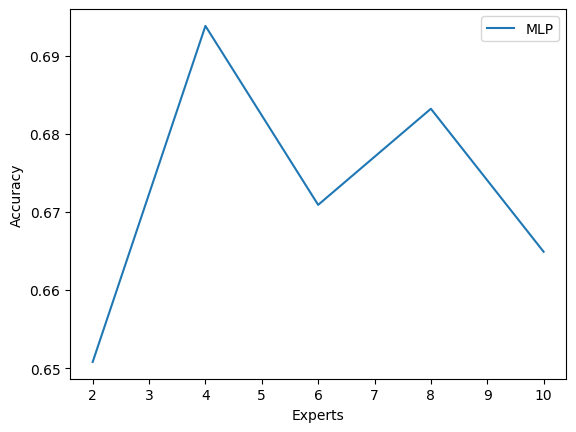

In [29]:
import matplotlib.pyplot as plt

def PlotGraph(X, Y1):
    plt.plot(X, Y1, label = 'MLP')
    # plt.plot(X, Y2, label = "Val")

    plt.xlabel("Experts")
    plt.ylabel("Accuracy")

    plt.legend(loc='best')
    plt.show()
X=[2,4,6,8,10]
# observations =[0.7007, 0.6984, 0.7068, 0.6678, 0.6468]
PlotGraph(X,observations)

In [ ]:
print(len(train_dataset))
subset_size = len(train_dataset)//5

# train_subset, val_subset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), int(len(train_dataset) * 0.15)], generator=torch.Generator().manual_seed(1))

no_experts= 5

fraction = 1/no_experts
total = len(train_dataset)
list_for_split = [int(total*fraction)]*no_experts

op = torch.utils.data.random_split(train_dataset,list_for_split,generator = torch.Generator().manual_seed(1))
type(op)
